# Text mining on `final_triticeae` dataset

In [2]:
library(tm, warn.conflicts = FALSE)
library(NLP, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(parallel)
library(foreach, warn.conflicts = FALSE)
library(doParallel)
library(purrr, warn.conflicts = FALSE)
library(RVenn)
library(cowplot)

Loading required package: NLP
Loading required package: iterators

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [3]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refpapers/")
getwd()

[1] "/mnt/filer/projects/comparative_triticeae/phenotype/flower_development/refpapers"

## 1. Data import

In [4]:
trit <- readRDS("final_triticeae.rds")
str(trit)
trit <- arrange(trit, desc(year))
tail(trit)

'data.frame':	80826 obs. of  5 variables:
 $ pmid    : chr  "32231884" "32231040" "32230597" "32230394" ...
 $ title   : chr  "Proximate composition, functional properties and quantitative analysis of benzoyl peroxide and benzoic acid in "| __truncated__ "Determination of Glyphosate in Dried Wheat by <sup>1</sup>H-NMR Spectroscopy." "Review of the genus Eurygaster (Hemiptera: Heteroptera: Scutelleridae) of Russia." "Description of Pratylenchoides ojcowensis sp. nov. (Nematoda: Merlinidae) from Polish Jurassic Highland." ...
 $ abstract: chr  "Extensive milling processes have deprived wheat flour from essential nutrients. The objective of the current st"| __truncated__ "A wheat field was sprayed with a dosage of 1.1 kg a.i./ha Roundup PowerMax 10 days before harvest. The <sup>1</"| __truncated__ "Six species of the genus Eurygaster Laporte, 1833 are currently recorded from the territory of the Russian Fede"| __truncated__ "A new species of the genus Pratylenchoides has been described. I

,pmid,title,abstract,year,journal
,<chr>,<chr>,<chr>,<chr>,<chr>
80821,4157536,[Effect of ferulic acid on alpha-amylase formation and on the germination of barley].,NA,1965,Archives internationales de physiologie et de biochimie
80822,4157535,[Activation and inhibition of alpha-amylase formation during the germination of barley].,NA,1965,Archives internationales de physiologie et de biochimie
80823,4157738,The formation of o-coumaroyl-beta-glucoside from coumarin-2-14C in barley embryos.,NA,1965,Archives internationales de physiologie et de biochimie
80824,5833367,Studies on carbohydrate-metabolizing enzymes. 11. The hydrolysis of lichenin by enzyme preparations from malted barley and Rhizopus arrhizus.,NA,1965,The Biochemical journal
80825,5832296,Studies on carbohydrate-metabolizing enzymes. 10. Barley beta-glucosidases.,NA,1965,The Biochemical journal
80826,5830068,[On the structure of beta-amylase from barley and malt. 13. (On seed proteins)].,NA,1965,Hoppe-Seyler's Zeitschrift fur physiologische Chemie


## 2. Creating & Inspecting Corpus from Dataframe
The dataframe passed to `DataframeSource()` must have a specific structure:
* Column one must be called `doc_id` and contain a unique string for each row.
* Column two must be called `text` with "UTF-8" encoding.
* Any other columns, 3+ are considered metadata.

Including more data in original `final_triticeae.rds` table (publishing country, date) should be considered for more analysis!

### 2.1 Data-wrangling to reach desired format on `trit`:

In [5]:
summary(trit)

     pmid              title             abstract             year          
 Length:80826       Length:80826       Length:80826       Length:80826      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
   journal         
 Length:80826      
 Class :character  
 Mode  :character  

In [6]:
# Merge "title" into "abstract" column and bind again, later need to delete old "abstract"
title_abstract <- paste0(trit$title, trit$abstract, sep=" ")
str(title_abstract)
tabstract <- as.data.frame(title_abstract, stringsAsFactors = FALSE)
trit_mergedtitle <- bind_cols(trit, tabstract)
summary(trit_mergedtitle)
head(trit_mergedtitle)

 chr [1:80826] "Proximate composition, functional properties and quantitative analysis of benzoyl peroxide and benzoic acid in "| __truncated__ ...


     pmid              title             abstract             year          
 Length:80826       Length:80826       Length:80826       Length:80826      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
   journal          title_abstract    
 Length:80826       Length:80826      
 Class :character   Class :character  
 Mode  :character   Mode  :character  

,pmid,title,abstract,year,journal,title_abstract
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,32231884,"Proximate composition, functional properties and quantitative analysis of benzoyl peroxide and benzoic acid in wheat flour samples: effect on wheat flour quality.","Extensive milling processes have deprived wheat flour from essential nutrients. The objective of the current study was to assess the nutritive quality of commercial wheat flour (soft flour (SF)) through analyses of proximate composition and functional properties as well as quantification of benzoyl peroxide (BPO; added as bleaching agent in the SF) by comparing the results with whole wheat flour (WF; never received any additives). The samples included commercial SF purchased from the local supplier of different flour mills (who use BPO as additive) and a control sample without additives was prepared by grinding the seeds harvested from wheat (<i>Triticum aestivum</i> L.; Inqulab 91) crop grown in the experimental field of University of Agriculture, Faisalabad, under optimized field conditions without any fertilizers and insecticides. Functional properties (including bulk density, water absorption capacity, oil absorption capacity, emulsifying activity, foaming capacity, least gelatinization concentration and gelatinization temperature) and proximate composition (including moisture content, ash contents, crude protein, gluten and starch contents) were determined and compared for all the samples. Benzoyl peroxide (BPO) and Benzoic Acid (BA) quantification was performed through High Performance Liquid Chromatography. Finally dietary intake was estimated for BPO and BA. Results showed that SF had lesser fiber, protein and ash contents, whereas, higher damaged starch, fat, gluten and bulk density. A parallel experiment under selected conditions (temperature, time and solute concentration) showed dissociation of BPO into BA soon after the exposure. Observed BA range (13.77 mg/g after 16 h) in SF and exposure level assessment (44.3 ± 1.36 mg/kg/BW) showed higher intake of BA on the consumption of SF. The results revealed the superiority of WF over SF in nutritive qualities as well as free of toxicants such as BA.",2020,PeerJ,"Proximate composition, functional properties and quantitative analysis of benzoyl peroxide and benzoic acid in wheat flour samples: effect on wheat flour quality.Extensive milling processes have deprived wheat flour from essential nutrients. The objective of the current study was to assess the nutritive quality of commercial wheat flour (soft flour (SF)) through analyses of proximate composition and functional properties as well as quantification of benzoyl peroxide (BPO; added as bleaching agent in the SF) by comparing the results with whole wheat flour (WF; never received any additives). The samples included commercial SF purchased from the local supplier of different flour mills (who use BPO as additive) and a control sample without additives was prepared by grinding the seeds harvested from wheat (<i>Triticum aestivum</i> L.; Inqulab 91) crop grown in the experimental field of University of Agriculture, Faisalabad, under optimized field conditions without any fertilizers and insecticides. Functional properties (including bulk density, water absorption capacity, oil absorption capacity, emulsifying activity, foaming capacity, least gelatinization concentration and gelatinization temperature) and proximate composition (including moisture content, ash contents, crude protein, gluten and starch contents) were determined and compared for all the samples. Benzoyl peroxide (BPO) and Benzoic Acid (BA) quantification was performed through High Performance Liquid Chromatography. Finally dietary intake was estimated for BPO and BA. Results showed that SF had lesser fiber, protein and ash contents, whereas, higher damaged starch, fat, gluten and bulk density. A parallel experiment under selected conditions (temperature, time and solute concentration) showed diss

In [7]:
# drop "abstract" column
trit_new <- subset(trit_mergedtitle, select = -abstract)
summary(trit_new)

     pmid              title               year             journal         
 Length:80826       Length:80826       Length:80826       Length:80826      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
 title_abstract    
 Length:80826      
 Class :character  
 Mode  :character  

In [8]:
# Create doc_id column
doc_id <- c(1:80826)
id <- as.data.frame(doc_id)
trit_with_id <- bind_cols(trit_new, id)
summary(trit_with_id)

     pmid              title               year             journal         
 Length:80826       Length:80826       Length:80826       Length:80826      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 title_abstract         doc_id     
 Length:80826       Min.   :    1  
 Class :character   1st Qu.:20207  
 Mode  :character   Median :40414  
                    Mean   :40414  
                    3rd Qu.:60620  
                    Max.   :80826  

In [9]:
# Rename abstract to text
trit_ready <- rename(trit_with_id, text = title_abstract)
summary(trit_ready)

     pmid              title               year             journal         
 Length:80826       Length:80826       Length:80826       Length:80826      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     text               doc_id     
 Length:80826       Min.   :    1  
 Class :character   1st Qu.:20207  
 Mode  :character   Median :40414  
                    Mean   :40414  
                    3rd Qu.:60620  
                    Max.   :80826  

In [10]:
# Reordering
trit_reordered <- trit_ready[, c(6, 5, 1, 2, 3, 4)]
summary(trit_reordered)

     doc_id          text               pmid              title          
 Min.   :    1   Length:80826       Length:80826       Length:80826      
 1st Qu.:20207   Class :character   Class :character   Class :character  
 Median :40414   Mode  :character   Mode  :character   Mode  :character  
 Mean   :40414                                                           
 3rd Qu.:60620                                                           
 Max.   :80826                                                           
     year             journal         
 Length:80826       Length:80826      
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

### 2.2 Create Corpus from reordered Dataframe

In [11]:
trit_source <- DataframeSource(trit_reordered)
trit_corpus <- VCorpus(trit_source)
# VCorpus object is a nested list, or list of lists. 
# VCorpus = Volatile Corpus which exist only in the memory not saved permanently
# For permanent creation use PCorpus
# At each index of the VCorpus object, there is a PlainTextDocument object, 
# which is a list containing actual text data (content), and some corresponding metadata (meta)
# VCorpus = PlainTextDocument1(content + metadata) + PlainTextDocument2(content + metada)
print(trit_corpus)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 4
Content:  documents: 80826


In [12]:
inspect(trit_corpus[30:32])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 4
Content:  documents: 3

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 2246

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 1976

[[3]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 1764



In [13]:
inspect(trit_corpus[[30]])
# alternatively: trit_corpus[[30]][1]
# same with: content(trit_corpus[[30]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 2246

Impacts of drought and nitrogen enrichment on leaf nutrient resorption and root nutrient allocation in four Tibetan plant species.Plant nutrient resorption, a process by which plant withdraws nutrients from senescing structures to developing tissues, can significantly affect plant growth, litter decomposition and nutrient cycling. Global change factors, such as nitrogen (N) deposition and altered precipitation, may mediate plant nutrient resorption and allocation. The ongoing global change is accompanied with increased N inputs and drought frequency in many regions. However, the interactive effects of increased N availability and drought on plant nutrient-responses remain largely unclear. In a pot experiment, we examined the impacts of N enrichment and drought on leaf N and phosphorous (P) resorption and root nutrient allocation in four species from the Qinghai-Tibet Plateau, including two graminoid species (Kobresia capillifoli

In [14]:
meta(trit_corpus[[80826]])
# here metadata is printed for the x-th element of the corpus

  author       : character(0)
  datetimestamp: 2020-09-15 14:39:50
  description  : character(0)
  heading      : character(0)
  id           : 80826
  language     : en
  origin       : character(0)

In [15]:
#inspect oldest publications
meta(trit_corpus) %>% filter(year == 1965)

pmid,title,year,journal
<chr>,<chr>,<chr>,<chr>
5890521,"Retained placenta, abortions and abnormal calves from beef cows fed all-barley rations.",1965,The Canadian veterinary journal = La revue veterinaire canadienne
5835785,Gibberellic acid: action in barley endosperm does not require endogenous auxin.,1965,"Science (New York, N.Y.)"
5830538,Strontium-90 in Canadian wheat from the 1963 crop year.,1965,Radiological health data and reports
5827911,Wheat proteins. II. Changes in the protein composition of Triticum vulgare during the life cycle of the plant.,1965,Journal of the science of food and agriculture
5833319,Cross protection and mutual exclusion by three strains of barley yellow dwarf virus in Avena sativa L.,1965,Virology
5834513,"Efficiency of egg production of three types of caged layers fed diets containing maize, oats or barley as the main cereal ingredient.",1965,British poultry science
5897189,"Studies in rats given a barley product mixed up in food. Growth, fertility, stress, intestinal function, longevity.",1965,Nutritio et dieta; European review of nutrition and dietetics
5831104,The effect of kinetin on nucleic acids and nucleases of excised barley leaves.,1965,Plant physiology
5831098,Physiological effects of gibberellic acid. 8. Growth retardants on barley endosperm.,1965,Plant physiology


## 3. Metadata management
* adding **pmid**, **title** (as description), **year** and **journal** to metadata on local level (= to each document inside the corpus) for later easier identification:
* (this step is unnecessary, can be skipped, here I did it for experimenting)

In [16]:
sapply(trit, class)

pmid       title    abstract        year     journal 
"character" "character" "character" "character" "character"

In [17]:
meta(trit_corpus, tag = "pmid", type = "local") <- trit$pmid
meta(trit_corpus, tag = "description", type = "local") <- trit$title
meta(trit_corpus, tag = "year", type = "local") <- trit$year
meta(trit_corpus, tag = "journal", type = "local") <- trit$journal

In [18]:
meta(trit_corpus[[80826]])

  author       : character(0)
  datetimestamp: 2020-09-15 14:39:50
  description  : [On the structure of beta-amylase from barley and malt. 13. (On seed proteins)].
  heading      : character(0)
  id           : 80826
  language     : en
  origin       : character(0)
  pmid         : 5830068
  year         : 1965
  journal      : Hoppe-Seyler's Zeitschrift fur physiologische Chemie

## 4. Transformations & Cleaning functions
### Common preprocessing functions include:
* `tolower()`: Make all characters lowercase
* `removePunctuation()`: Remove all punctuation marks
* `removeNumbers()`: Remove numbers
* `stripWhitespace()`: Remove excess whitespace
* `removeWords()` specifically for collections of 174 most commonly used words in English with `stopwords("en")`
* `tm_map` is used to apply cleaning functions on a corpus, it takes two arguments, a corpus and a cleaning function
* for compatibility, `base R` and `qdap` functions need to be wrapped in `content_transformer()`

In [19]:
clean_corpus <- function(corpus){
  corpus <- tm_map(corpus, content_transformer(tolower))
  corpus <- tm_map(corpus, removePunctuation)
  corpus <- tm_map(corpus, removeNumbers)
  corpus <- tm_map(corpus, removeWords, words = c(stopwords("en"), "known", "activated", "increasing", "significant", "investigated", "applied", "concentration", "study", "showed", "improved", "enhanced", "two", "using", "results", "also", "increase", "use", "active"))
  corpus <- tm_map(corpus, stripWhitespace)
  return(corpus)
}
trit_corpus <- clean_corpus(trit_corpus)

In [20]:
inspect(trit_corpus[[30]])

<<PlainTextDocument>>
Metadata:  10
Content:  chars: 1760

impacts drought nitrogen enrichment leaf nutrient resorption root nutrient allocation four tibetan plant speciesplant nutrient resorption process plant withdraws nutrients senescing structures developing tissues can significantly affect plant growth litter decomposition nutrient cycling global change factors nitrogen n deposition altered precipitation may mediate plant nutrient resorption allocation ongoing global change accompanied increased n inputs drought frequency many regions however interactive effects increased n availability drought plant nutrientresponses remain largely unclear pot experiment examined impacts n enrichment drought leaf n phosphorous p resorption root nutrient allocation four species qinghaitibet plateau including graminoid species kobresia capillifolia elymus nutans forb species delphinium kamaonense aster diplostephioides divergent resorption patterns within functional groups e nutans d kamaonense str

# 5. Create TDM or DTM
* TDM is often the matrix used for language analysis, because it is likely to have more terms than documents and life is generally easier with more rows than columns
* like in case of this analysis TDM is more handy as there are 80 826 documents (columns) given to 251 112 terms (rows)

In [103]:
library(wordcloud)
library(SnowballC)
library(ggplot2)
library(ggwordcloud)
library(RColorBrewer)

In [23]:
#stemming of words
trit_stemmed <- tm_map(trit_corpus, stemDocument, language = "english")

In [24]:
trit_tdm <- TermDocumentMatrix(trit_stemmed)
trit_m <- as.matrix(trit_tdm)
dim(trit_m)
trit_m <- rowSums(trit_m)
trit_m <- sort(trit_m, decreasing =TRUE)

[1] 251112  80826

 Named num [1:251112] 134928 57377 54164 53230 49253 ...
 - attr(*, "names")= chr [1:251112] "wheat" "protein" "gene" "plant" ...


,words,frequency
,<fct>,<dbl>
wheat,wheat,134928
protein,protein,57377
gene,gene,54164
plant,plant,53230
effect,effect,49253
differ,differ,45657


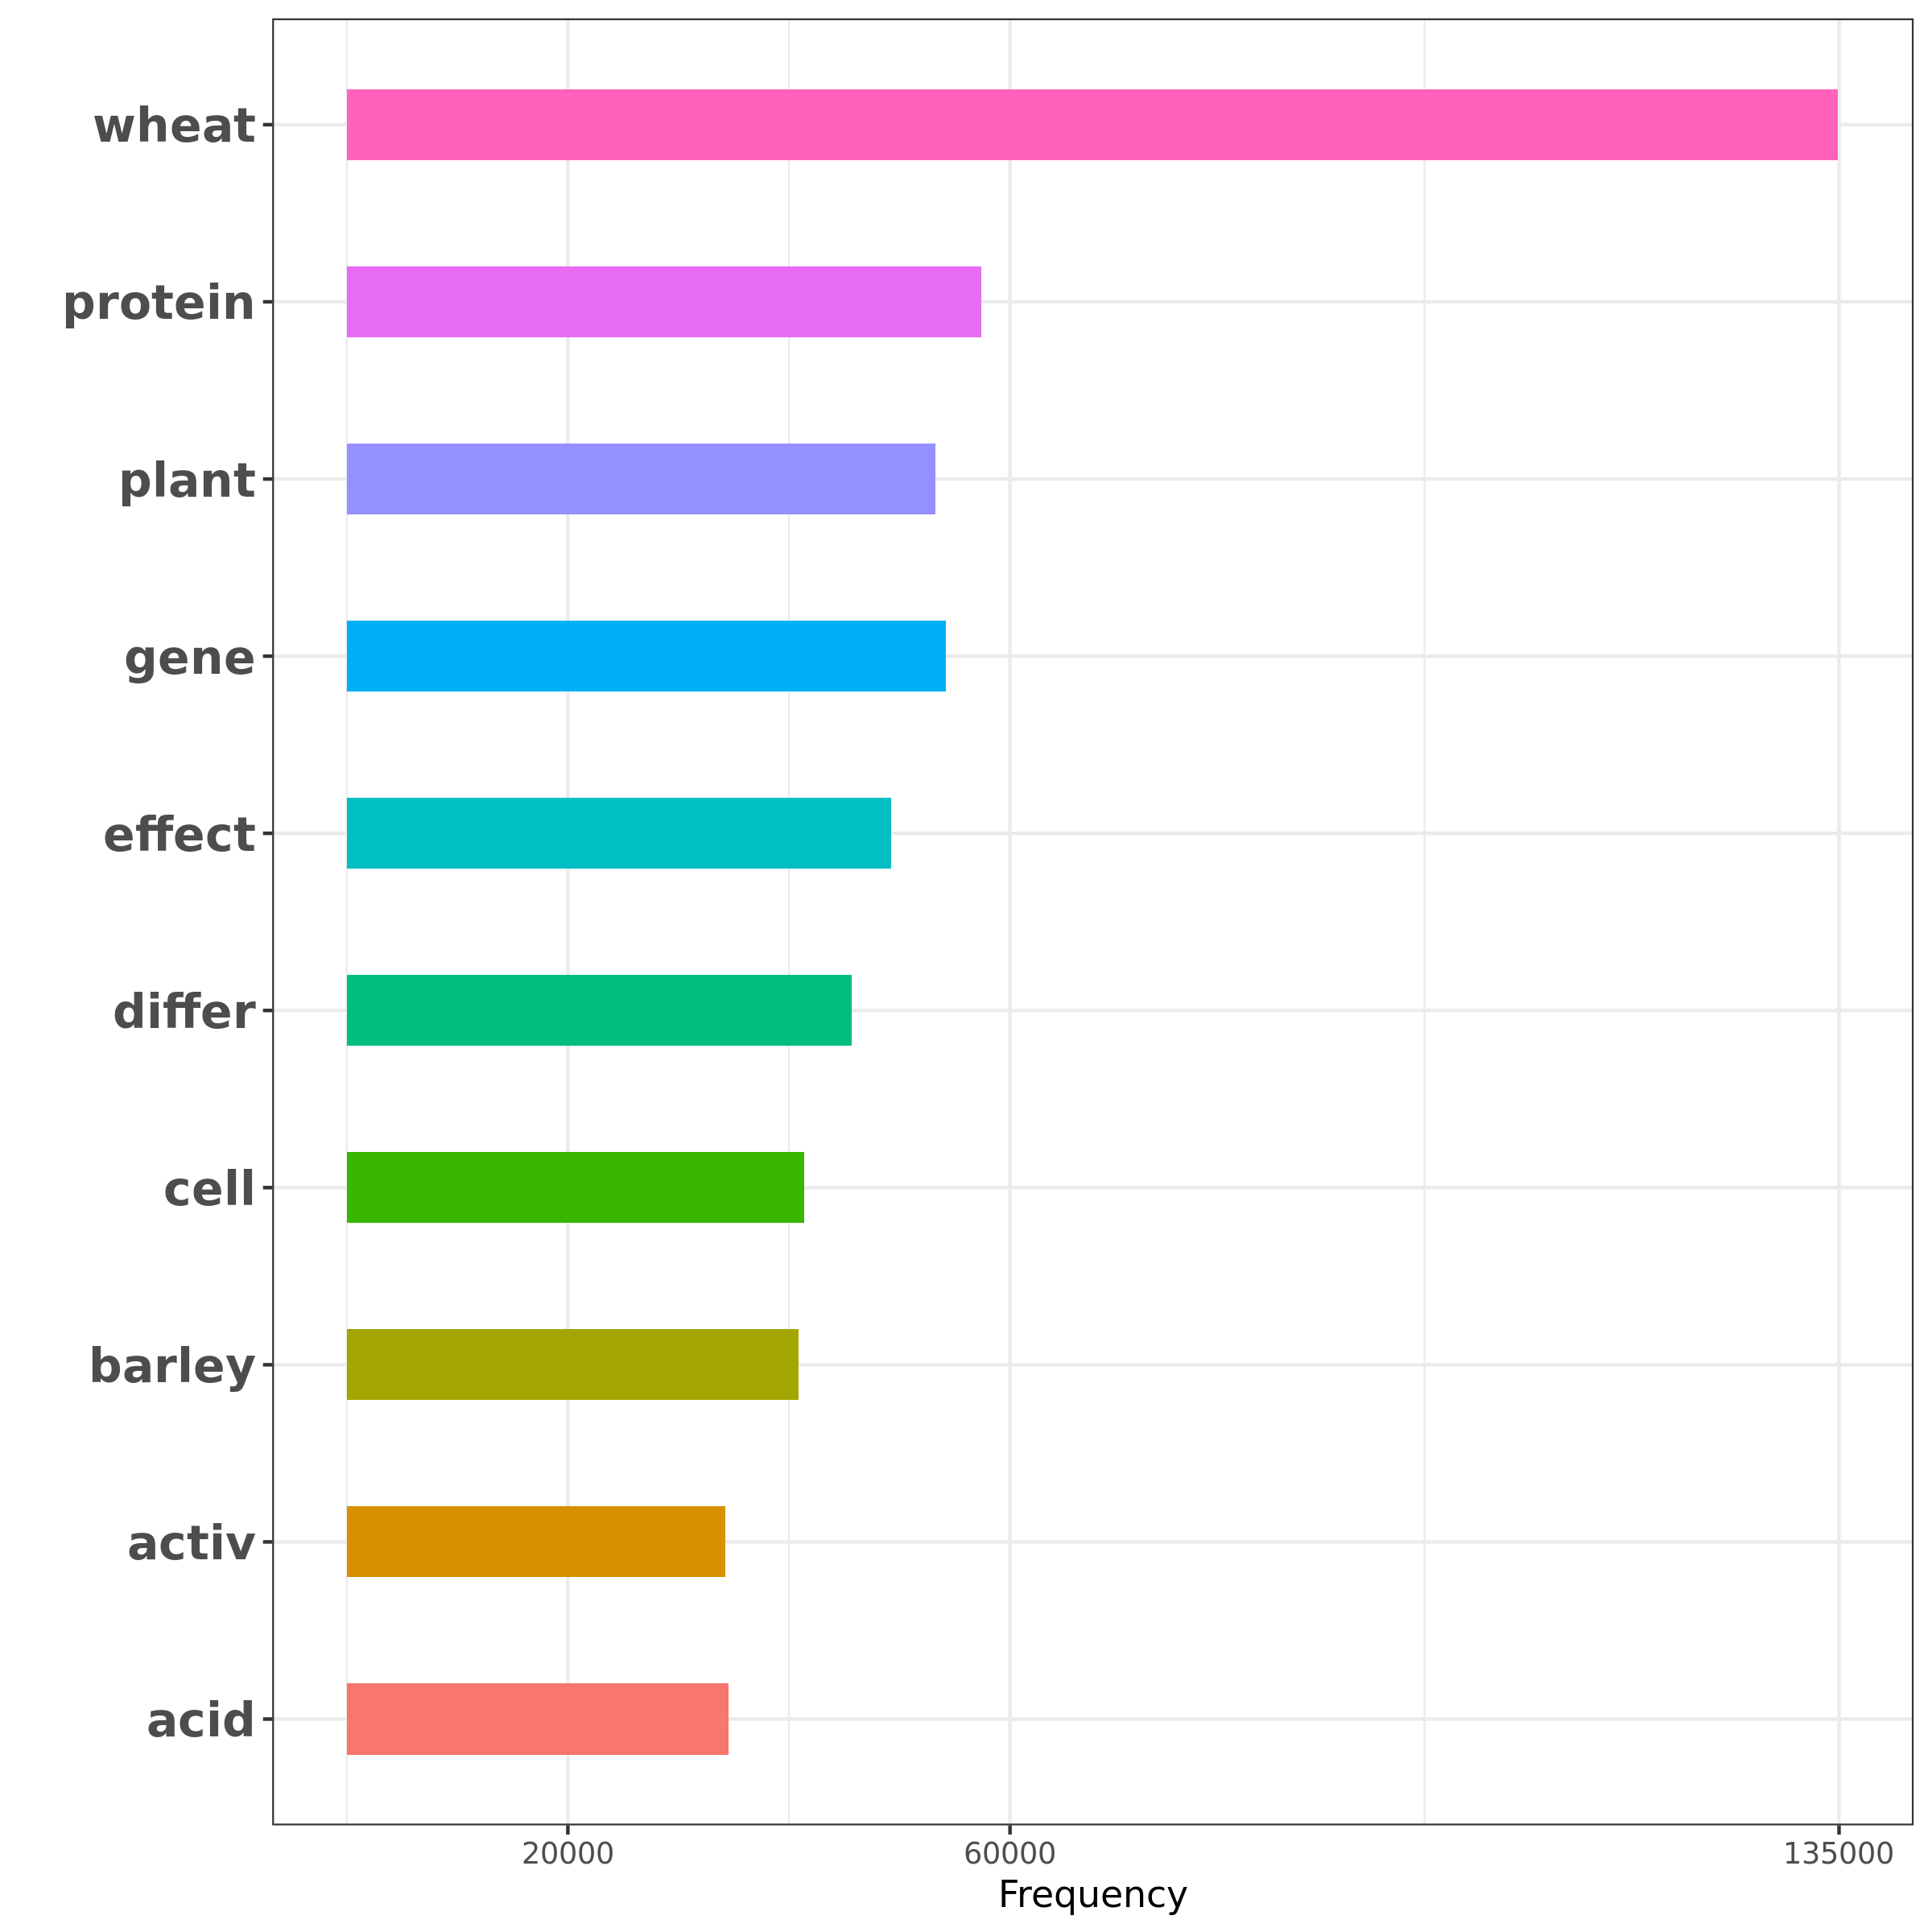

In [244]:
glimpse(trit_m)
trit_top <- as.data.frame(trit_m[1:10])
trit_top <- cbind(Row.Names = rownames(trit_top), trit_top)
colnames(trit_top) <- c("words", "frequency")
head(trit_top)

# expand color palette
colourCount = length(unique(trit_top$words))
getPalette = colorRampPalette(brewer.pal(9, "Pastel1"))
# use together with: + scale_fill_manual(values = getPalette(colourCount)) 

library(viridis)

ggplot(trit_top, aes(x = words, y = frequency, fill = words)) + geom_col(width = 0.4) + theme_bw() + scale_y_continuous(breaks =c(20000, 60000, 135000), limits=c(0, 135000))+ labs(x = "", y = "Frequency") + scale_color_viridis() + coord_flip() + theme(legend.position='none', axis.text.y = element_text(size = 14, face = "bold"))
#"springgreen4", horiz=T , las=1, xlab = )

freq <- ggplot(trit_top, aes(x = words, y = frequency, fill = words)) + geom_col(width = 0.4) + theme_bw() + scale_y_continuous(breaks =c(20000, 60000, 135000), limits=c(0, 135000))+ labs(x = "", y = "Frequency") + scale_color_viridis() + coord_flip() + theme(legend.position='none', axis.text.y = element_text(size = 14, face = "bold"))

 Named num [1:251112] 134928 57377 54164 53230 49253 ...
 - attr(*, "names")= chr [1:251112] "wheat" "protein" "gene" "plant" ...


,words,frequency,angle
,<fct>,<dbl>,<dbl>
1,wheat,134928,0
2,protein,57377,90
3,gene,54164,90
4,plant,53230,90
5,effect,49253,90
6,differ,45657,90


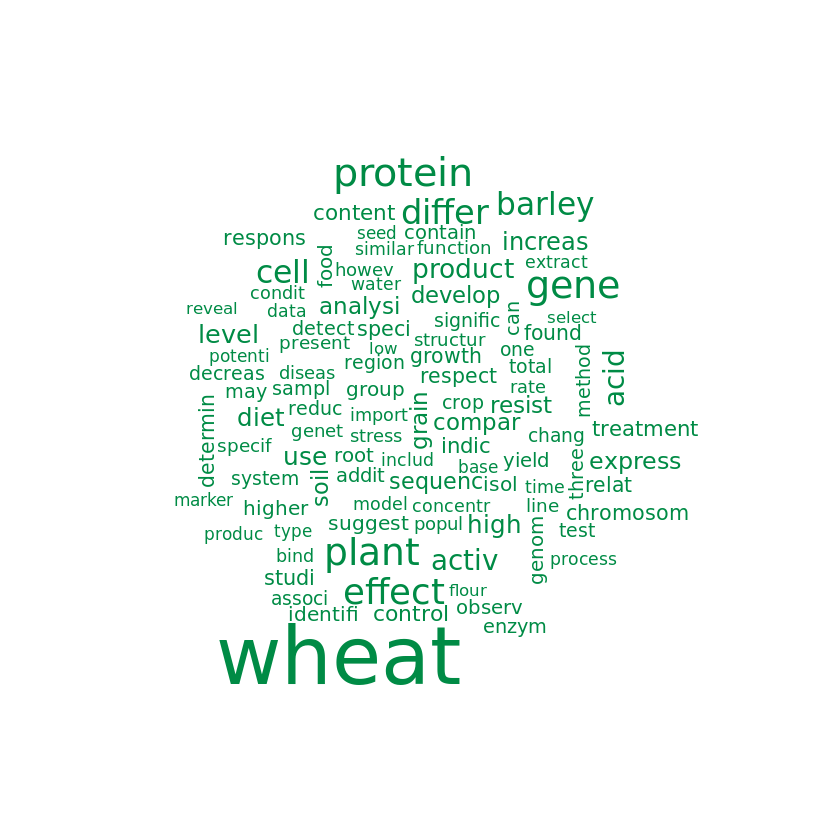

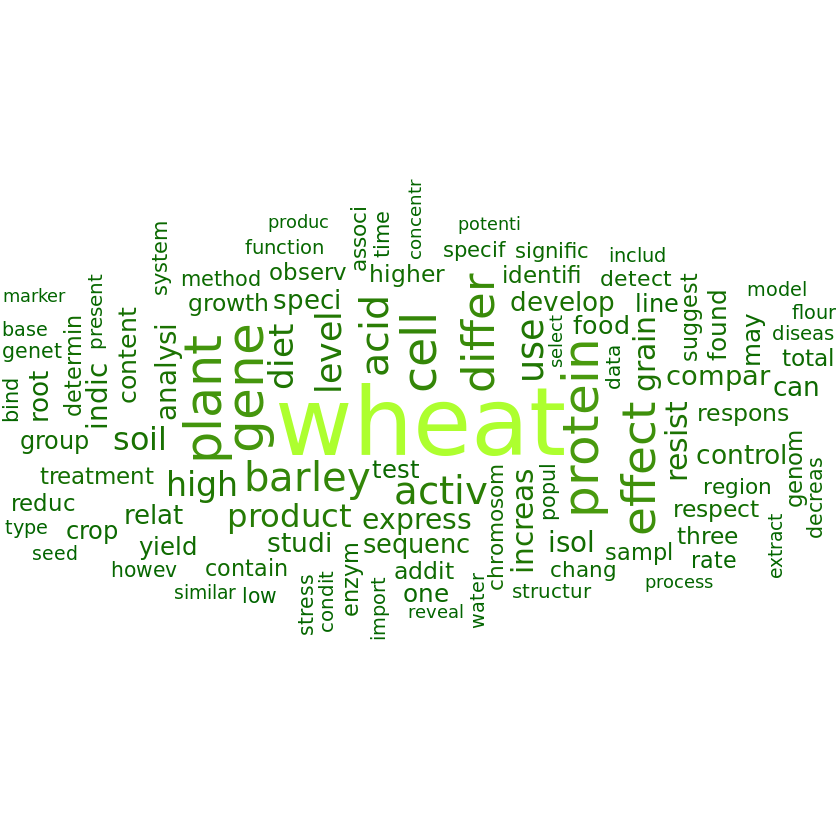

In [122]:
terms_vec <- names(trit_m)
wc <- wordcloud(terms_vec, trit_m, max.words = 100, colors = "springgreen4")


glimpse(trit_m)
trit_all <- as.data.frame(trit_m[1:100])
trit_all <- cbind(Row.Names = rownames(trit_all), trit_all)
colnames(trit_all) <- c("words", "frequency")

trit_all <- trit_all %>%
  mutate(angle = 90 * sample(c(0, 1), n(), replace = TRUE, prob = c(60, 40)))
head(trit_all)

wc <- ggplot(data = trit_all, 
       aes(label = words, size = frequency, angle = angle, col = frequency)) + 
  geom_text_wordcloud_area(eccentricity = 0.4)+
  scale_size_area(max_size = 20)+
  scale_color_gradient(low = "darkgreen", high = "greenyellow")+
  theme_void()
wc

# 6. Filter corpus with keywords to create flower-PMID list

The 15 keywords I considered for filtering are:
* **anther, fertility, floral, floret, flower, inflorescence, lemma, palea, panicle, pistil, pollen, spike, stamen, stigma, style**
* in single-word searches I had to exclude (because misleading): flower (sunflower and cow on barley diet...), lemma (plasmalemma), style, stigma, spike (hplc studies), pollen (allergies), fertility (misleading 23836161(PMID))
* **final solution:** use combinations especially for ambiguous words
    - how: 
        1. use grep of single searchwords (with foreach for-loop), than do pairwise intersection of each list (thus achieve a combination of 2 words for each list) and finally unify them - with the use of `RVenn` package
        (it is possible to use two expression within one grep, like: `tm_filter(trit_triticeae, FUN = function(x) any(grep("flower fertility", content(x))))`
        2. search for multiple words in text-doc-matrix columns - too complicated way, but can be tried whether it gives the same result

In [21]:
print(trit_corpus)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 4
Content:  documents: 80826


In [22]:
# Re-Filter corpus with original searchwords (from NCBI download) -> to be sure of their presence in the abstracts! and thus the article's focus is on them
# Original Pubmed query searched through the entire articles, any mention in any paragraph meant to include them in my initial 81 000 results
trit_triticeae <- tm_filter(trit_corpus, FUN = function(x) any(grep("(wheat|bread wheat|common wheat|Triticum aestivum|barley|domestic barley|Hordeum vulgare|Triticeae|Hordeinae|Agropyron|Anthosachne|Australopyrum|Campeiostachys|Connorochloa|Critesion|Crithopsis|Douglasdeweya|Elymus|Eremopyrum|Festucopsis|Henrardia|Heteranthelium|Hordelymus|Hordeum|Hystrix|Kengyilia|Leymus|Pascopyrum|Peridictyon|Psathyrostachys|Pseudoroegneria|Secale|Stenostachys|Taeniatherum|Triticinae|Aegilops|Amblyopyrum|Dasypyrum|Haynaldia|Lophopyrum|Thinopyrum|Triticum
)", perl=TRUE, content(x))))
print(trit_triticeae)
# only 68 753 articles are truly dealing with Triticeae research (rest must be side-mentions in main-text, but not in the abstract, thus can be excluded)
# use this in an UpsetR along with full-database, wheat and barley to compare scales
# further searches should be inside this set only

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 4
Content:  documents: 68753


In [23]:
# filtering with 15 searchwords into single lists of pmid-s combined into a list object
searchwords <- c("anther", "fertility", "floral", "floret", "flower", "inflorescence", "lemma", "palea", "panicle", "pistil", "pollen", "spike", "stamen", "stigma", "style")
#foreach gives back a list by default, specifying .combine="" just made life complicated
cl <- makeCluster(16)
registerDoParallel(cl)
system.time({
a <- foreach(i=searchwords, .packages = "tm") %dopar% {
     meta(tm_filter(trit_triticeae, FUN = function(x) any(grep(i, content(x)))))$pmid
}
                  })
stopCluster(cl)
str(a)

   user  system elapsed 
 11.897   2.345  32.394 

List of 15
 $ : chr [1:435] "32131726" "32066846" "32048207" "31963482" ...
 $ : chr [1:621] "32181421" "32179904" "32174526" "32173682" ...
 $ : chr [1:234] "32172750" "32113949" "32111029" "32061090" ...
 $ : chr [1:214] "32172750" "32103263" "31914168" "31875911" ...
 $ : chr [1:1698] "32229608" "32226438" "32214360" "32210989" ...
 $ : chr [1:182] "32131726" "32088154" "32043419" "31640618" ...
 $ : chr [1:282] "32103263" "31982426" "31936205" "31808224" ...
 $ : chr [1:56] "31494998" "31245178" "30868385" "30841851" ...
 $ : chr [1:78] "32199367" "32174943" "32161624" "31889983" ...
 $ : chr [1:69] "32019527" "31943230" "31888472" "31165748" ...
 $ : chr [1:602] "32181421" "32180947" "32066846" "32038666" ...
 $ : chr [1:1790] "32231040" "32229393" "32214360" "32211011" ...
 $ : chr [1:56] "32181421" "32019527" "31888472" "31401233" ...
 $ : chr [1:64] "32105432" "31820048" "31557302" "31168160" ...
 $ : chr [1:285] "32176103" "32148306" "31915642" "31895924" ...


In [24]:
#intersection & union of created single-searchword lists
search = Venn(a)
intersected <- overlap_pairs(search)
tail(intersected)
# result is a list of 120 intersection pairs with different sizes, each list now contains PMIDs with at least 2 searchwords existing inside their articles
intersected = Venn(intersected)
final <- unite(intersected)
str(final)
# the final list has 898 PMIDs from 80826 initial searches each of them 2x overlapping with 15 keywords

$Set_12...Set_13
 [1] "31165748" "31046676" "28676817" "29506473" "28515146" "27208226"
 [7] "25966171" "26505395" "24563243" "23192388" "24162202" "22395962"
[13] "15692181" "18794174" "17704940" "16858583" "11851918" "10198085"
[19] "7715728" 

$Set_12...Set_14
[1] "30899270" "30474697" "28676817" "22791834" "22186277"

$Set_12...Set_15
[1] "26471973" "24603887" "22791834" "22087742"

$Set_13...Set_14
[1] "28676817"

$Set_13...Set_15
character(0)

$Set_14...Set_15
[1] "22791834"

 chr [1:898] "31963482" "31628536" "31473791" "31009129" "31729646" ...


In [25]:
# create list with 3x overlapping terms
third <- overlap_pairs(intersected)
third = Venn(third)
final_third <- unite(third)
str(final_third)

 chr [1:308] "29581960" "26157170" "24762030" "24162539" "30518316" ...


In [26]:
# Save lists for extracting GeneIDs in the next steps
# 2x-overlap list
write.table(final, file = "PMIDlist_flower.tsv", row.names = FALSE, sep="\t")
saveRDS(final, file = "PMIDlist_flower.rds")
#3 3x-overlap list
write.table(final_third, file = "PMIDlist_flower_3.tsv", row.names = FALSE, sep="\t")
saveRDS(final_third, file = "PMIDlist_flower_3.rds")

# 7. Quality control
* random testing of the filtered PMID articles
* already found false positives in `final` which has 2x-overlap of keyterms: **5/13**
    - PMID 26972421: Imidazolium salts with antifungal potential for the control of head blight of wheat caused by Fusarium graminearum.
        - existing searchwords: flower, spike & wheat
    - PMID 30474697: Involvement of the two L-lactate dehydrogenase in development and pathogenicity in Fusarium graminearum.
        - stigma, spike & wheat
    - PMID 26471973: The wheat durable, multipathogen resistance gene Lr34 confers partial blast resistance in rice.
        - spike, (life)style & wheat
    - PMID 22087742: The quantitative analysis of thiamin and riboflavin and their respective vitamers in fermented alcoholic beverages.
        - spkie (HPLC), (beer) style & wheat
* solution: creating 3x-keyword containing list `final_third`, also found false positives: **1/12** checked random PMIDs
    - PMID 29506473: Three endoplasmic reticulum-associated fatty acyl-coenzyme a reductases were involved in the production of primary alcohols in hexaploid wheat (Triticum aestivum L.).

In [27]:
# 2x-overlap list - 898 PMID
head(final)
tail(final)

[1] "31963482" "31628536" "31473791" "31009129" "31729646" "31185903"

[1] "12324597" "28526911" "8232200"  "30474697" "26471973" "22087742"

In [28]:
# 3x-overlap list - 308 PMID
head(final_third)
tail(final_third)

[1] "29581960" "26157170" "24762030" "24162539" "30518316" "28163591"

[1] "32019527" "26408275" "29506473" "26505395" "18794174" "28676817"

# 8. Visualise overlap of keyterms
* source: https://github.com/hms-dbmi/UpSetR

In [29]:
library(UpSetR, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(grid)
library(dplyr, warn.conflicts = FALSE)

In [30]:
#creating sets for UpsetR
#full set
fullset <- meta(trit_corpus)$pmid
str(fullset)
# set of triticeae containing articles
triticeae <- meta(tm_filter(trit_corpus, FUN = function(x) any(grep("(wheat|bread wheat|common wheat|Triticum aestivum|barley|domestic barley|Hordeum vulgare|Triticeae|Hordeinae|Agropyron|Anthosachne|Australopyrum|Campeiostachys|Connorochloa|Critesion|Crithopsis|Douglasdeweya|Elymus|Eremopyrum|Festucopsis|Henrardia|Heteranthelium|Hordelymus|Hordeum|Hystrix|Kengyilia|Leymus|Pascopyrum|Peridictyon|Psathyrostachys|Pseudoroegneria|Secale|Stenostachys|Taeniatherum|Triticinae|Aegilops|Amblyopyrum|Dasypyrum|Haynaldia|Lophopyrum|Thinopyrum|Triticum)", perl=TRUE, content(x)))))$pmid
str(triticeae)
# sets of single searches for display only
wheat <- meta(tm_filter(trit_corpus, FUN = function(x) any(grep("wheat", content(x)))))$pmid
str(wheat)
barley <- meta(tm_filter(trit_corpus, FUN = function(x) any(grep("barley", content(x)))))$pmid
str(barley)

 chr [1:80826] "32231884" "32231040" "32230597" "32230394" "32230099" ...
 chr [1:68753] "32231884" "32231040" "32230597" "32229608" "32229393" ...
 chr [1:56257] "32231884" "32231040" "32230597" "32229393" "32229110" ...
 chr [1:17252] "32229608" "32229337" "32229335" "32227786" "32226437" ...


In [31]:
anther <- unlist(a[1])
fertility <- unlist(a[2])
floral <- unlist(a[3])
floret <- unlist(a[4])
flower <- unlist(a[5])
inflorescence <- unlist(a[6])
lemma <- unlist(a[7])
palea <- unlist(a[8])
panicle <- unlist(a[9])
pistil <- unlist(a[10])
pollen <- unlist(a[11])
spike <- unlist(a[12])
stamen <- unlist(a[13])
stigma <- unlist(a[14])
style <- unlist(a[15])
selection <- final
str(flower)

 chr [1:1698] "32229608" "32226438" "32214360" "32210989" "32193575" ...


In [32]:
extra <- as.data.frame(meta(trit_corpus))
head(extra)

,pmid,title,year,journal
,<chr>,<chr>,<chr>,<chr>
1,32231884,"Proximate composition, functional properties and quantitative analysis of benzoyl peroxide and benzoic acid in wheat flour samples: effect on wheat flour quality.",2020,PeerJ
2,32231040,Determination of Glyphosate in Dried Wheat by <sup>1</sup>H-NMR Spectroscopy.,2020,"Molecules (Basel, Switzerland)"
3,32230597,Review of the genus Eurygaster (Hemiptera: Heteroptera: Scutelleridae) of Russia.,2020,Zootaxa
4,32230394,Description of Pratylenchoides ojcowensis sp. nov. (Nematoda: Merlinidae) from Polish Jurassic Highland.,2020,Zootaxa
5,32230099,"Prionotropis xausi, a new species of Thrinchinae (Orthoptera: Pamphagidae) from Catalonia (northeast of the Iberian Peninsula).",2020,Zootaxa
6,32229608,Differential effects of day-night cues and the circadian clock on the barley transcriptome.,2020,Plant physiology


In [33]:
#ggplot(barley) + geom_density(aes(x = yield, fill = site), alpha = 0.2)
y <- extra %>% group_by(year) %>% summarise(trit = n())
head(y)
#ggplot(y) + geom_col(aes(x = year, y = trit), alpha = 0.2)
#ggplot(y) + geom_histogram(aes(x = year))

year,trit
<chr>,<int>
1965,16
1966,108
1967,148
1968,232
1969,211
1970,217


In [34]:
listInput <- list(fullset, triticeae, wheat, barley, anther, fertility, floral, floret, flower, inflorescence, lemma, palea, panicle, pistil, pollen, spike, stamen, stigma, style, selection)
u <- fromList(listInput)
colnames(u) <- c("PubMed Query", "Triticeae", "Wheat", "Barley", "Anther", "Fertility", "Floral", "Floret", "Flower", "Inflorescence", "Lemma", "Palea", "Panicle", "Pistil", "Pollen", "Spike", "Stamen", "Stigma", "Style", "Flower-selection") 
str(u)

'data.frame':	80826 obs. of  20 variables:
 $ PubMed Query    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Triticeae       : int  1 1 1 0 0 1 1 1 1 1 ...
 $ Wheat           : int  1 1 1 0 0 0 1 0 0 1 ...
 $ Barley          : int  0 0 0 0 0 1 0 1 1 0 ...
 $ Anther          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Fertility       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Floral          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Floret          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Flower          : int  0 0 0 0 0 1 0 0 0 0 ...
 $ Inflorescence   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Lemma           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Palea           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Panicle         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Pistil          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Pollen          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Spike           : int  0 1 0 0 0 0 1 0 0 0 ...
 $ Stamen          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Stigma          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Style           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Flow

In [35]:
all <- bind_cols(extra, u)
colnames(all) <- c("PMID", "Title", "Year", "Journal", "PubMed Query", "Triticeae", "Wheat", "Barley", "Anther", "Fertility", "Floral", "Floret", "Flower", "Inflorescence", "Lemma", "Palea", "Panicle", "Pistil", "Pollen", "Spike", "Stamen", "Stigma", "Style", "Flower-selection")
all$Year <- as.integer(all$Year)
tail(all)

,PMID,Title,Year,Journal,PubMed Query,Triticeae,Wheat,Barley,Anther,Fertility,⋯,Lemma,Palea,Panicle,Pistil,Pollen,Spike,Stamen,Stigma,Style,Flower-selection
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
80821,4157536,[Effect of ferulic acid on alpha-amylase formation and on the germination of barley].,1965,Archives internationales de physiologie et de biochimie,1,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80822,4157535,[Activation and inhibition of alpha-amylase formation during the germination of barley].,1965,Archives internationales de physiologie et de biochimie,1,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80823,4157738,The formation of o-coumaroyl-beta-glucoside from coumarin-2-14C in barley embryos.,1965,Archives internationales de physiologie et de biochimie,1,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80824,5833367,Studies on carbohydrate-metabolizing enzymes. 11. The hydrolysis of lichenin by enzyme preparations from malted barley and Rhizopus arrhizus.,1965,The Biochemical journal,1,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80825,5832296,Studies on carbohydrate-metabolizing enzymes. 10. Barley beta-glucosidases.,1965,The Biochemical journal,1,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80826,5830068,[On the structure of beta-amylase from barley and malt. 13. (On seed proteins)].,1965,Hoppe-Seyler's Zeitschrift fur physiologische Chemie,1,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0


png 
  2

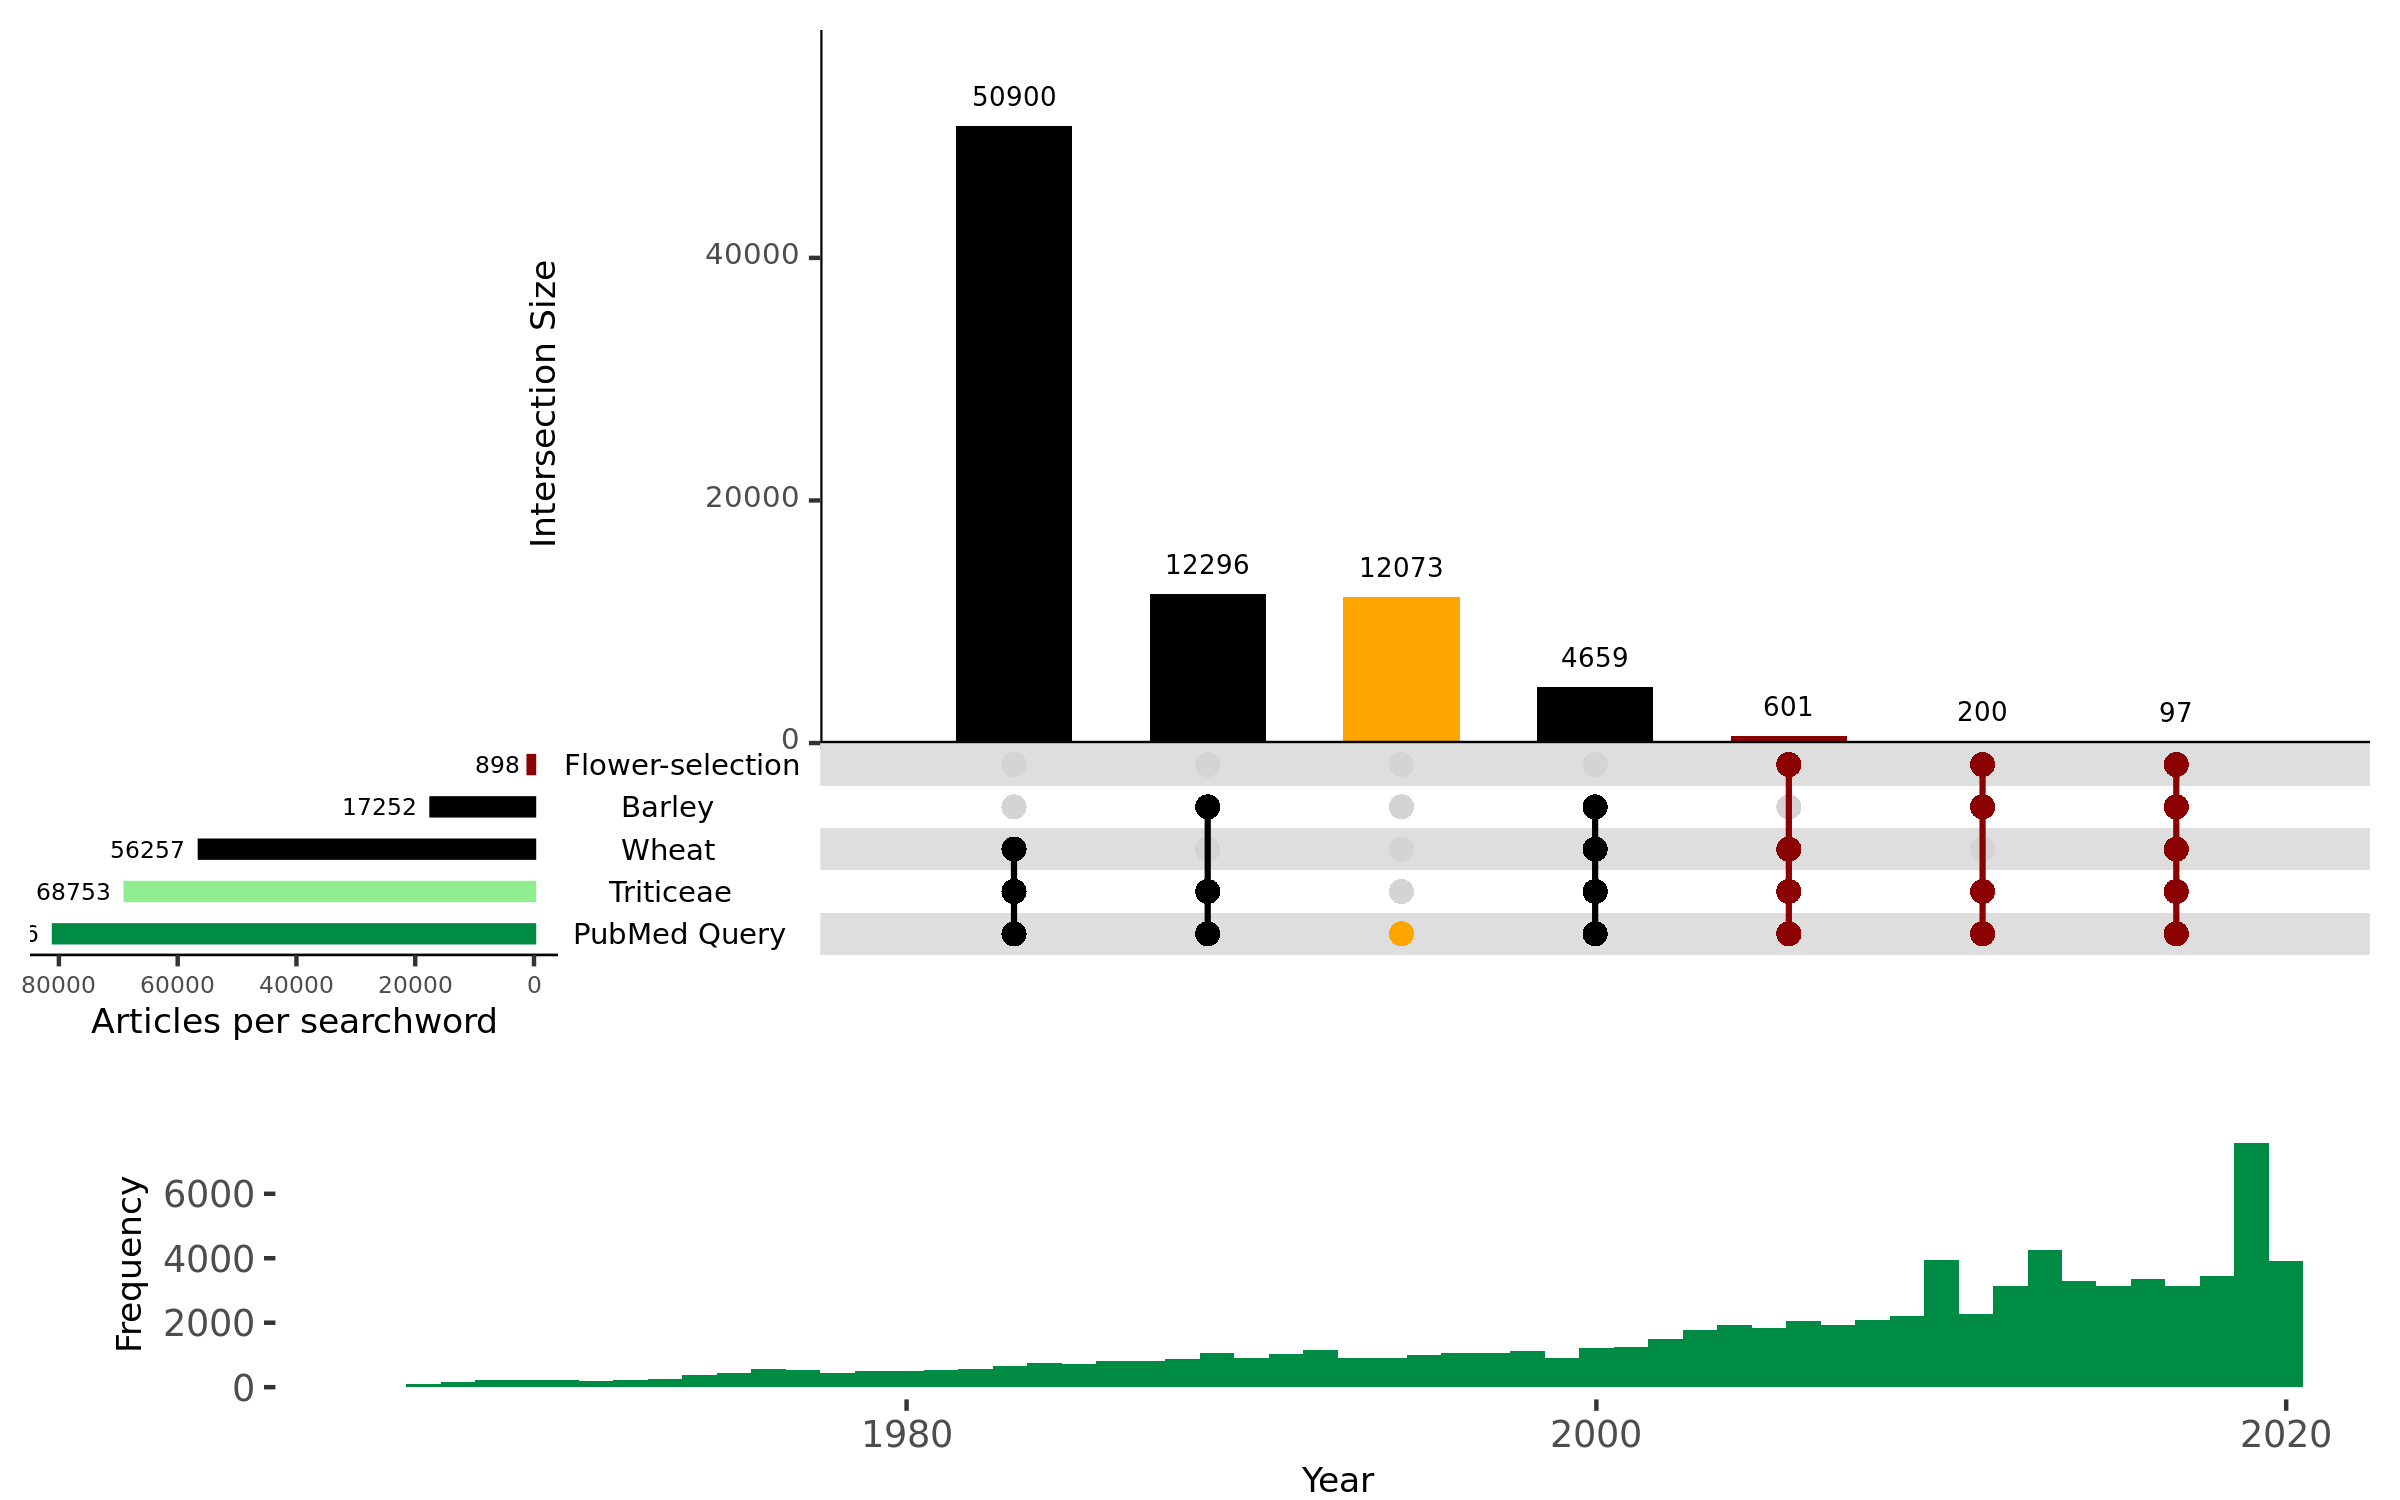

In [78]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)
# remake this plot to have Triticeae as corpus!
p1 <- upset(all, sets = c("PubMed Query", "Triticeae", "Wheat", "Barley", "Flower-selection"), nintersects = 10,
      order.by = "freq", main.bar.color = "black", matrix.color = "black", shade.color = "lightgrey", sets.bar.color =c("springgreen4","lightgreen","black","black", "red4"), matrix.dot.alpha = 30, shade.alpha = 0.75, att.color = "springgreen4",
      set_size.show = T, text.scale = c(1, 1, 1, 0.8, 1, 1), point.size = 2.5,
      queries = list(list(query = intersects, params = list("PubMed Query"), color = "orange", active = T), 
                     list(query = intersects, params = list("Flower-selection", "Barley", "PubMed Query", "Triticeae"), color = "red4", active = T),
                     list(query = intersects, params = list("Flower-selection", "Wheat", "PubMed Query", "Triticeae"), color = "red4", active = T),
                     list(query = intersects, params = list("Flower-selection", "Wheat", "Barley", "PubMed Query", "Triticeae"), color = "red4", active = T)),
      mainbar.y.label = "Intersection Size", sets.x.label = "Articles per searchword",
      attribute.plots=list(gridrows=40,plots=list(list(plot=histogram, x = "Year", queries = F))))
p1
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
png("upset_trit.png", units="in", width=8, height=5, res=300)
p1
dev.off()

png 
  2

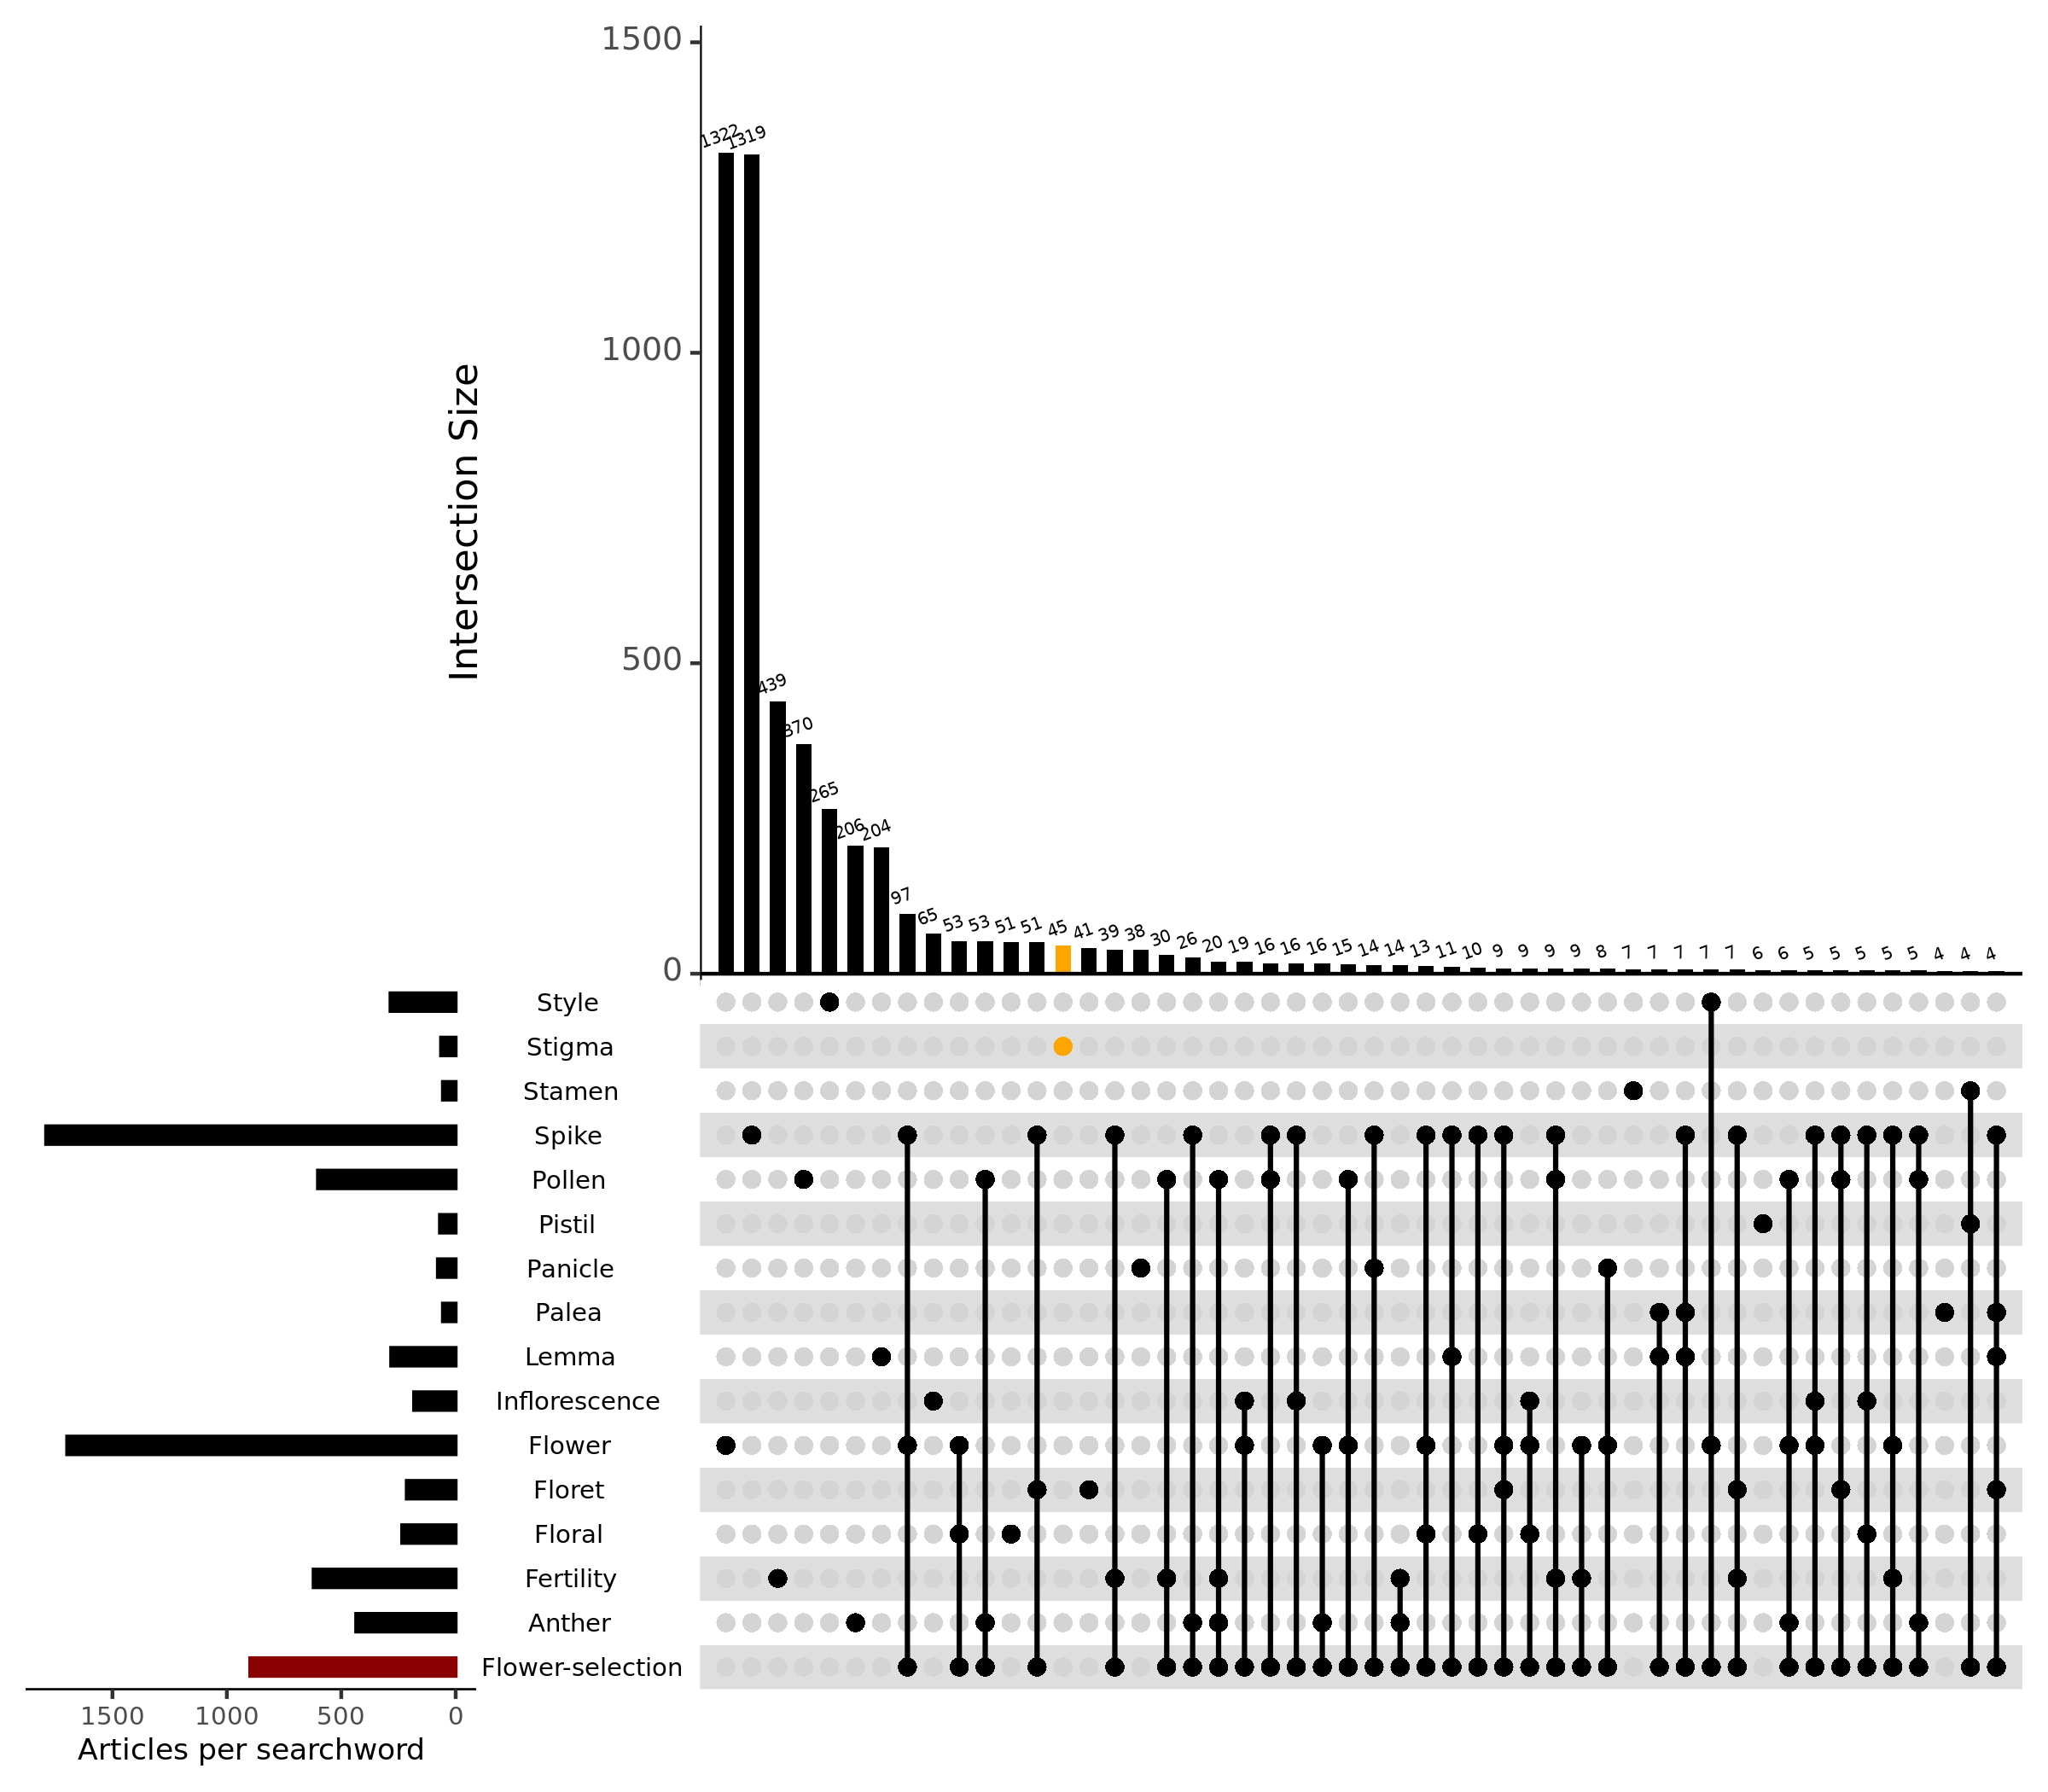

In [79]:
options(repr.plot.width = 8, repr.plot.height = 7, repr.plot.res = 300)

p2 <- upset(u, sets = c("Flower-selection", "Anther", "Fertility", "Floral", "Floret", "Flower", "Inflorescence", "Lemma", "Palea", "Panicle", "Pistil", "Pollen", "Spike", "Stamen", "Stigma", "Style"),
     nintersects = 50, mb.ratio = c(0.55, 0.45), order.by = "freq", keep.order = TRUE, number.angles = 20, text.scale = c(1.3, 1.3, 1, 1, 1, 0.75), 
      queries = list(list(query = intersects, params = list("Stigma"), color = "orange", active = T)),
      main.bar.color = "black", matrix.color = "black", sets.bar.color =c("red4","black","black","black","black","black","black","black","black","black","black","black","black","black","black","black"), shade.color = "lightgrey", matrix.dot.alpha = 60, shade.alpha = 0.75,
      mainbar.y.label = "Intersection Size", sets.x.label = "Articles per searchword")
p2
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
png("upset_flower.png", units="in", width=8, height=7, res=300)
p2
dev.off()

# 9. Filter corpus with keywords to create transcriptomic PMID list as a subset of flower-PMID list

In [38]:
# Transcriptomic papers do not have single GeneIDs ordered to them, but a large collection of genes identified - needs manual inspection!
# substract original trit_corpus with final flower PMID list to generate a corpus for flower papers
summary(trit_reordered)

     doc_id          text               pmid              title          
 Min.   :    1   Length:80826       Length:80826       Length:80826      
 1st Qu.:20207   Class :character   Class :character   Class :character  
 Median :40414   Mode  :character   Mode  :character   Mode  :character  
 Mean   :40414                                                           
 3rd Qu.:60620                                                           
 Max.   :80826                                                           
     year             journal         
 Length:80826       Length:80826      
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

In [39]:
pmid <- as.data.frame(final, rownames = FALSE)
colnames(pmid) <- "pmid"
summary(pmid)

       pmid    
 10198085:  1  
 10399553:  1  
 10399554:  1  
 10428875:  1  
 10449582:  1  
 10586878:  1  
 (Other) :892  

In [40]:
trit_transcript <- inner_join(trit_reordered, pmid, by = "pmid")
summary(trit_transcript)

Warning message:
“Column `pmid` joining character vector and factor, coercing into character vector”

     doc_id          text               pmid              title          
 Min.   :   49   Length:898         Length:898         Length:898        
 1st Qu.:12384   Class :character   Class :character   Class :character  
 Median :27783   Mode  :character   Mode  :character   Mode  :character  
 Mean   :28481                                                           
 3rd Qu.:42347                                                           
 Max.   :78646                                                           
     year             journal         
 Length:898         Length:898        
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

In [41]:
# re-generate corpus from flower related papers (trit_transcript)
transcript_source <- DataframeSource(trit_transcript)
transcript_corpus <- VCorpus(transcript_source)
print(transcript_corpus)
# cleaning again
transcript_corpus <- clean_corpus(transcript_corpus)
# create tdm to analyse flower related papers explicitly?

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 4
Content:  documents: 898


In [42]:
# include metadata
trit_transcript$pmid <- as.character(trit_transcript$pmid)
sapply(trit_transcript, class)
meta(transcript_corpus, tag = "pmid", type = "local") <- trit_transcript$pmid
meta(transcript_corpus, tag = "description", type = "local") <- trit_transcript$title

doc_id        text        pmid       title        year     journal 
  "integer" "character" "character" "character" "character" "character"

In [43]:
inspect(transcript_corpus[[200]])
meta(transcript_corpus[[200]])

<<PlainTextDocument>>
Metadata:  8
Content:  chars: 785

molecular mapping intermedium spikec intc nonbrittle rachis btr loci barley hordeum vulgare llateral spikelet fertility nonbrittle rachis key characters studying evolution barley fertility lateral spikelets controlled predominantly alleles vrs locus chromosome hl modified alleles intc locus chromosome hs nonbrittle rachis controlled alleles tightly linked loci btr btr chromosome hs paper presents integration intc btr loci molecular linkage maps barley intc locus mapped end chromosome hs cm distal mwg locus analysis followed composite interval mapping quantitative trait loci verified position intc locus linkage analysis recombinant inbred lines btr locus flanked aflp loci em em map distances cm cm respectively molecular markers will expedite highdensity mapping intc btr loci 


  author       : character(0)
  datetimestamp: 2020-09-15 14:50:04
  description  : Molecular mapping of the intermedium spike-c ( int-c) and non-brittle rachis 1 ( btr1) loci in barley ( Hordeum vulgare L.).
  heading      : character(0)
  id           : 10747
  language     : en
  origin       : character(0)
  pmid         : 12582565

In [44]:
# filtering with 6 searchwords into single lists of pmid-s combined into a list object
words <- c("differentially expressed", "comparative transcriptom", "rnaseq", "rna seq", "differential gene expression", "transcriptome")
#foreach gives back a list by default, specifying .combine="" just made life complicated
cl <- makeCluster(5)
registerDoParallel(cl)
system.time({
b <- foreach(i=words, .packages = "tm") %dopar% {
     meta(tm_filter(transcript_corpus, FUN = function(x) any(grep(i, content(x)))))$pmid
}
                  })
stopCluster(cl)
str(b)

   user  system elapsed 
  0.055   0.012   0.350 

List of 6
 $ : chr [1:40] "32066846" "32060572" "32019527" "31910796" ...
 $ : chr [1:8] "32019527" "31910796" "31165748" "31076487" ...
 $ : chr [1:20] "32181421" "32066846" "32060572" "31963482" ...
 $ : chr [1:9] "32019527" "31185903" "31076750" "29739311" ...
 $ : chr [1:5] "28531235" "27507961" "25886815" "25063396" ...
 $ : chr [1:41] "32019527" "31910796" "31835796" "31778224" ...


In [45]:
#intersection & union of created single-searchword lists
t_search = Venn(b)
intersected_trans <- overlap_pairs(t_search)
str(intersected_trans)
# result is a list of 15 intersection pairs with different sizes, each list now contains PMIDs with at least 2 searchwords existing inside their articles
intersected_trans = Venn(intersected_trans)
final_trans <- unite(intersected_trans)
str(final_trans)
# the final list has 20 PMIDs from 80826 initial searches

List of 15
 $ Set_1...Set_2: chr [1:4] "32019527" "31910796" "31165748" "31185903"
 $ Set_1...Set_3: chr [1:9] "32066846" "32060572" "31165748" "31729646" ...
 $ Set_1...Set_4: chr [1:4] "32019527" "31185903" "31076750" "25886815"
 $ Set_1...Set_5: chr "25886815"
 $ Set_1...Set_6: chr [1:16] "32019527" "31910796" "31778224" "31628536" ...
 $ Set_2...Set_3: chr [1:3] "31165748" "29581960" "29064514"
 $ Set_2...Set_4: chr [1:2] "32019527" "31185903"
 $ Set_2...Set_5: chr(0) 
 $ Set_2...Set_6: chr [1:6] "32019527" "31910796" "31165748" "31185903" ...
 $ Set_3...Set_4: chr "25517485"
 $ Set_3...Set_5: chr "28531235"
 $ Set_3...Set_6: chr [1:8] "31469444" "31165748" "29068370" "29064514" ...
 $ Set_4...Set_5: chr "25886815"
 $ Set_4...Set_6: chr [1:8] "32019527" "31185903" "31076750" "29739311" ...
 $ Set_5...Set_6: chr [1:2] "27507961" "25886815"
 chr [1:32] "32019527" "31910796" "31165748" "31185903" "32066846" ...


In [46]:
print(final_trans)

 [1] "32019527" "31910796" "31165748" "31185903" "32066846" "32060572"
 [7] "31729646" "29068370" "28484474" "28428792" "29143606" "26055625"
[13] "31076750" "25886815" "31778224" "31628536" "30337587" "28515146"
[19] "28241738" "25898130" "17207255" "29581960" "29064514" "22443345"
[25] "25517485" "28531235" "31469444" "25562483" "29739311" "26307377"
[31] "25707852" "27507961"


In [47]:
# Save list for intersection
write.table(final_trans, file = "PMIDlist_transcript.tsv", row.names = FALSE, sep="\t")
saveRDS(final_trans, file = "PMIDlist_transcript.rds")

## Visualize transcriptomic-papers with UpsetR

In [48]:
#creating sets for UpsetR
#full set
fullset_t <- meta(transcript_corpus)$pmid
str(fullset_t)

 chr [1:898] "32214360" "32181421" "32172750" "32131726" "32103263" ...


In [49]:
differentially_expressed <- unlist(b[1])
comparative_transcriptom <- unlist(b[2])
rnaseq <- unlist(b[3])
rna_seq <- unlist(b[4])
differential_gene_expression <- unlist(b[5])
transcriptome <- unlist(b[6])
str(differentially_expressed)

 chr [1:40] "32066846" "32060572" "32019527" "31910796" "31790345" ...


In [50]:
extra_t <- as.data.frame(meta(transcript_corpus))
head(extra_t)

,pmid,title,year,journal
,<chr>,<chr>,<chr>,<chr>
1,32214360,Wheat individual grain-size variance originates from crop development and from specific genetic determinism.,2020,PloS one
2,32181421,Identification of genes involved in male sterility in wheat (<i>Triticum aestivum</i> L.) which could be used in a genic hybrid breeding system.,2020,Plant direct
3,32172750,Inferring vascular architecture of the wheat spikelet based on resource allocation in the branched head<sup>t</sup> (bh<sup>t</sup>-A1) near isogenic lines.,2020,Functional plant biology : FPB
4,32131726,Evolution of PHAS loci in the young spike of Allohexaploid wheat.,2020,BMC genomics
5,32103263,Mis-expression of a transcriptional repressor candidate provides a molecular mechanism for the suppression of awns by Tipped 1 in wheat.,2020,Journal of experimental botany
6,32066846,Identification and validation of reference genes for RT-qPCR normalization in wheat meiosis.,2020,Scientific reports


In [51]:
listInput <- list(fullset_t, differentially_expressed, comparative_transcriptom, rnaseq, rna_seq, differential_gene_expression, transcriptome, final_trans)
u1 <- fromList(listInput)
colnames(u1) <- c("Flower-selection", "Differentially expressed", "Comparative transcriptom", "RNAseq", "RNA seq", "Differential gene expression", "Transcriptome", "RNA-seq selection") 
str(u1)

'data.frame':	898 obs. of  8 variables:
 $ Flower-selection            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Differentially expressed    : int  0 0 0 0 0 1 0 0 0 1 ...
 $ Comparative transcriptom    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ RNAseq                      : int  0 1 0 0 0 1 0 0 0 1 ...
 $ RNA seq                     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Differential gene expression: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Transcriptome               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ RNA-seq selection           : int  0 0 0 0 0 1 0 0 0 1 ...


In [52]:
all1 <- bind_cols(extra_t, u1)
colnames(all1) <- c("PMID", "Title", "Year", "Journal", "Flower-selection", "Differentially expressed", "Comparative transcriptom", "RNAseq", "RNA seq", "Differential gene expression", "Transcriptome", "RNA-seq selection") 
all1$Year <- as.integer(all1$Year)
tail(all1)

,PMID,Title,Year,Journal,Flower-selection,Differentially expressed,Comparative transcriptom,RNAseq,RNA seq,Differential gene expression,Transcriptome,RNA-seq selection
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
893,7080085,Cytogenetic hazards from agricultural chemicals. 4. Sequential screening in the barley progeny test for cytogenetic activity of some systemic fungicides and a metabolite.,1982,Toxicology letters,1,0,0,0,0,0,0,0
894,7437483,Change in ultrastructure of apical cells in wheat shoots in ontogenesis.,1981,Biology bulletin of the Academy of Sciences of the USSR,1,0,0,0,0,0,0,0
895,6936981,[The relevance of cereal grain pollen in hayfever (author's transl)].,1981,Wiener klinische Wochenschrift. Supplementum,1,0,0,0,0,0,0,0
896,726054,[Inheritance of certain quantitative and qualitative traits in a system of diallele barley crosses].,1979,TSitologiia i genetika,1,0,0,0,0,0,0,0
897,661826,[Genetic change in the waxy trait of barley under the influence of wild type DNA. Analysis of the composition of starch and the electrophoretic spectrum of caryopsis hordein from altered plants and the retention of these changes to the fourth generation].,1978,Molekuliarnaia biologiia,1,0,0,0,0,0,0,0
898,1145741,[Variability in the fertility of pollen from M2 mutants of spring durum wheat].,1975,TSitologiia i genetika,1,0,0,0,0,0,0,0


png 
  2

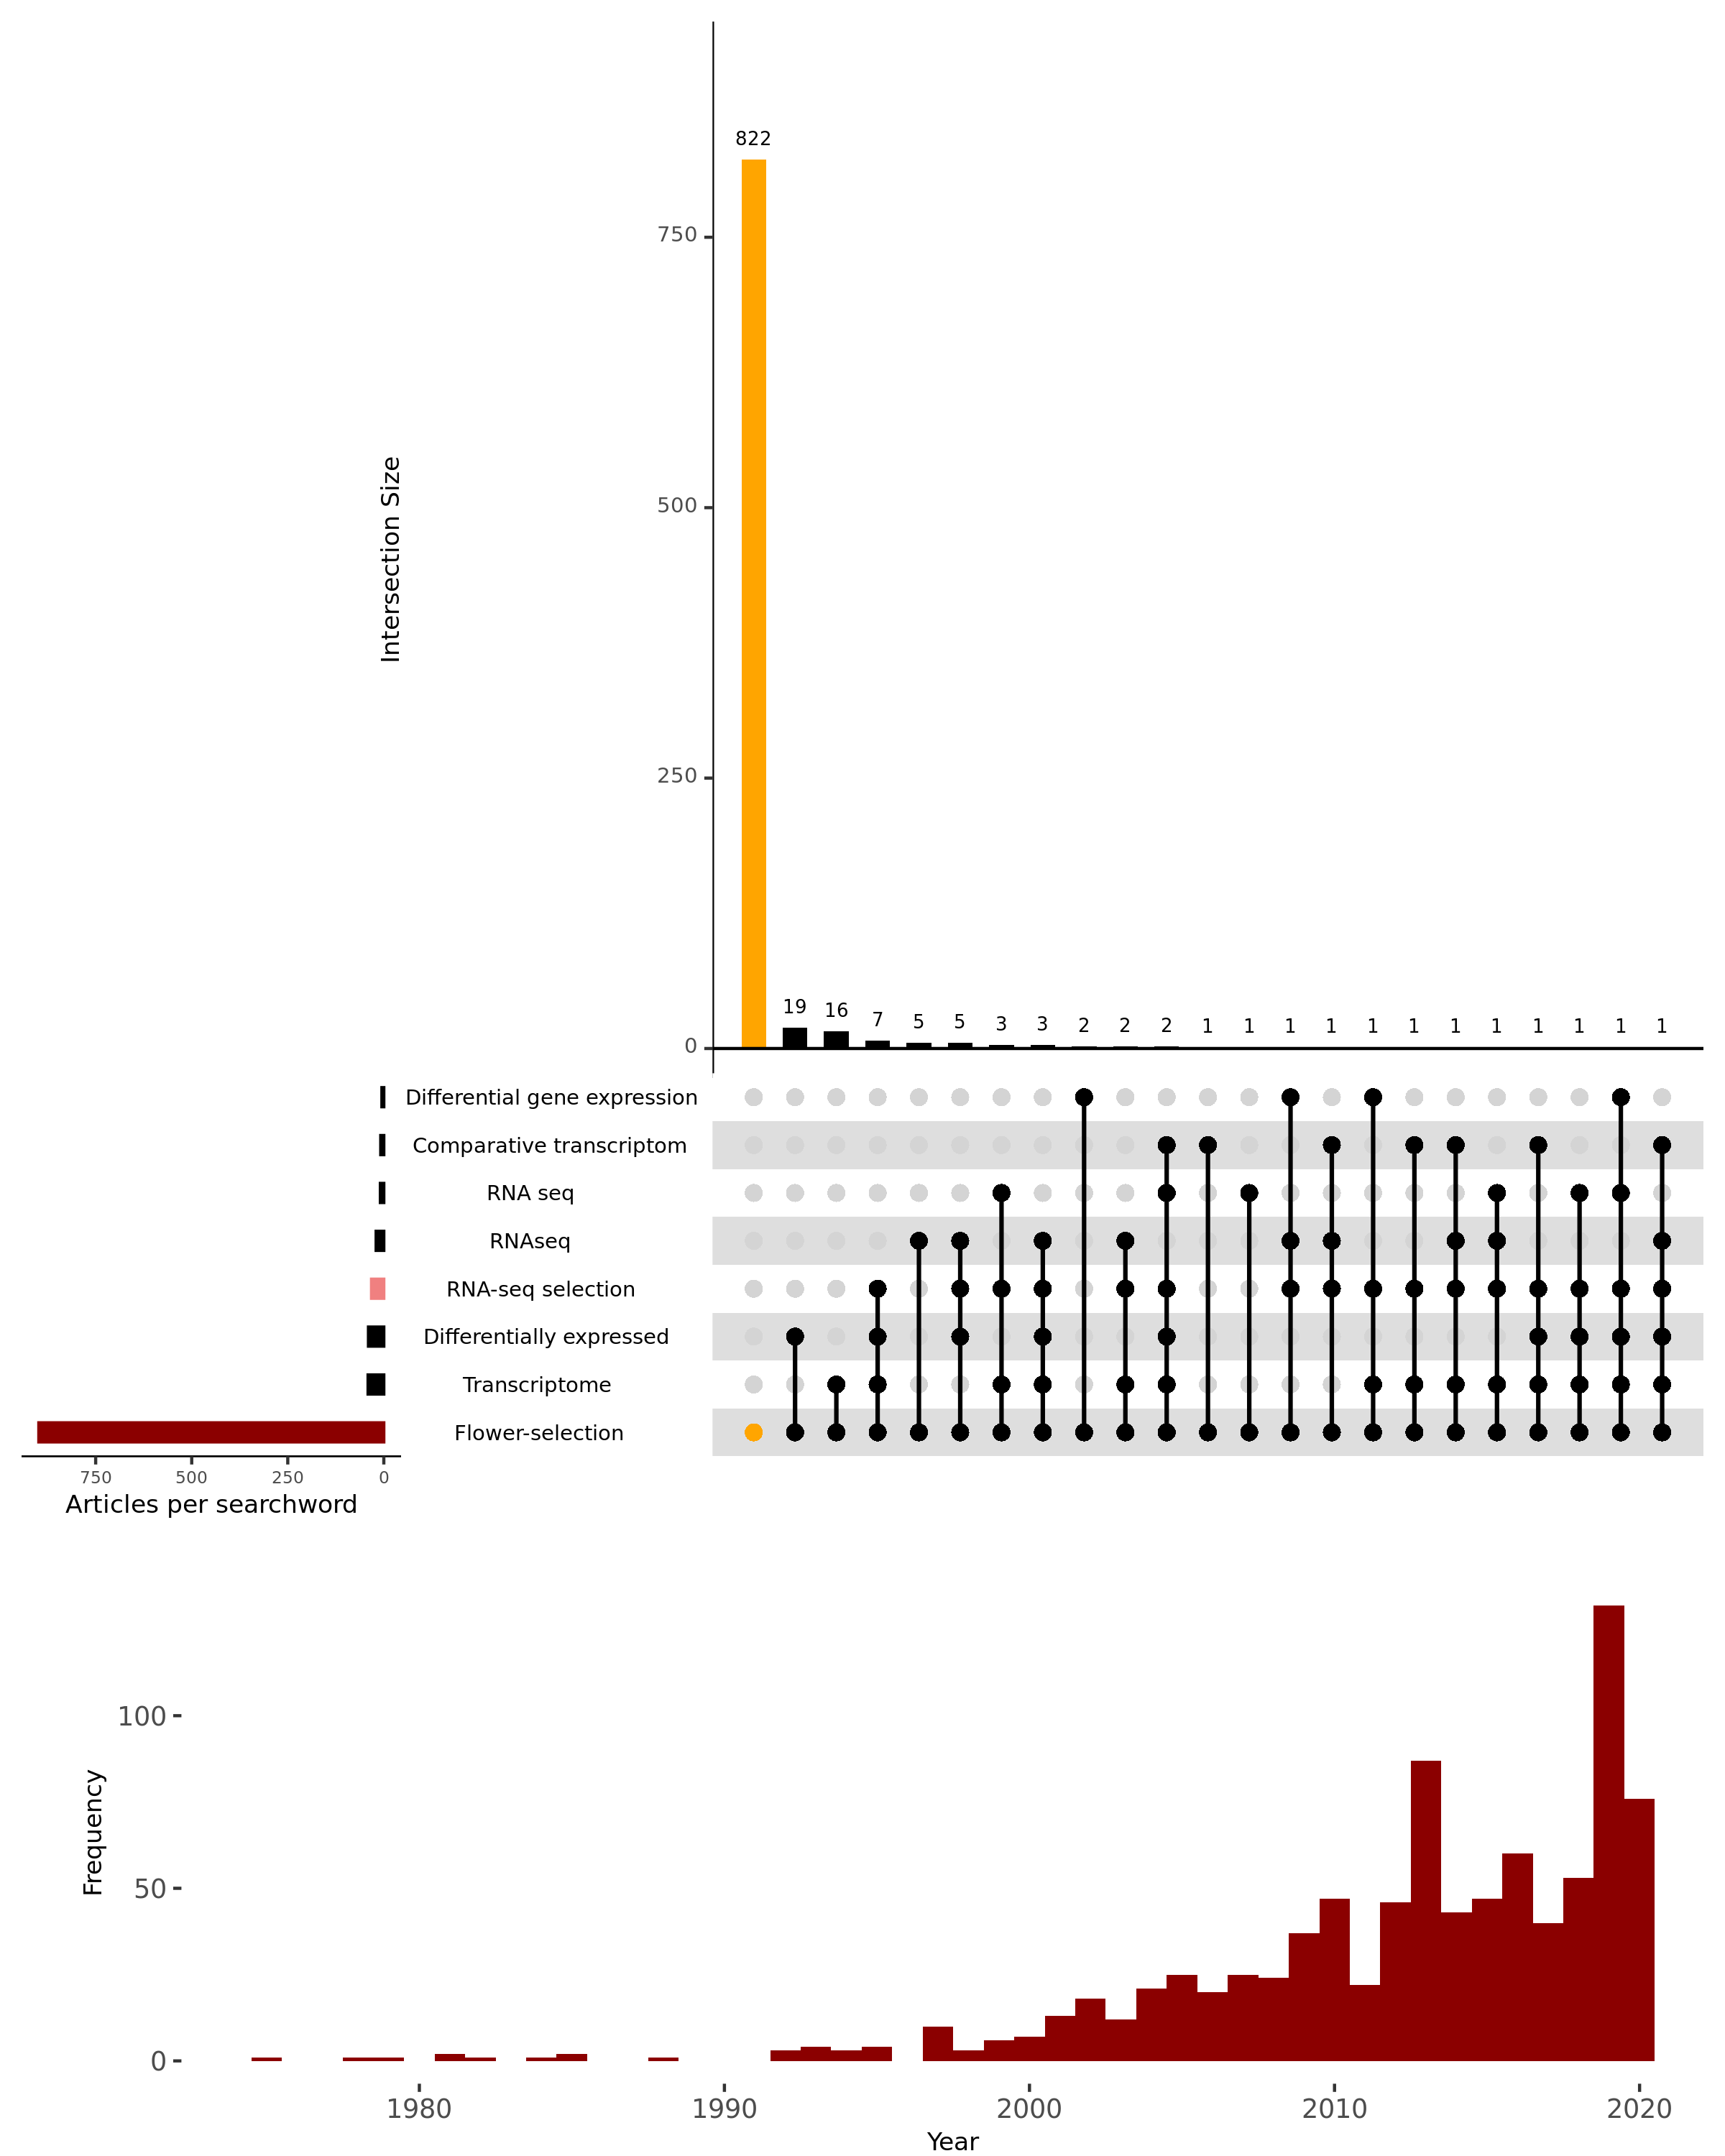

png 
  2

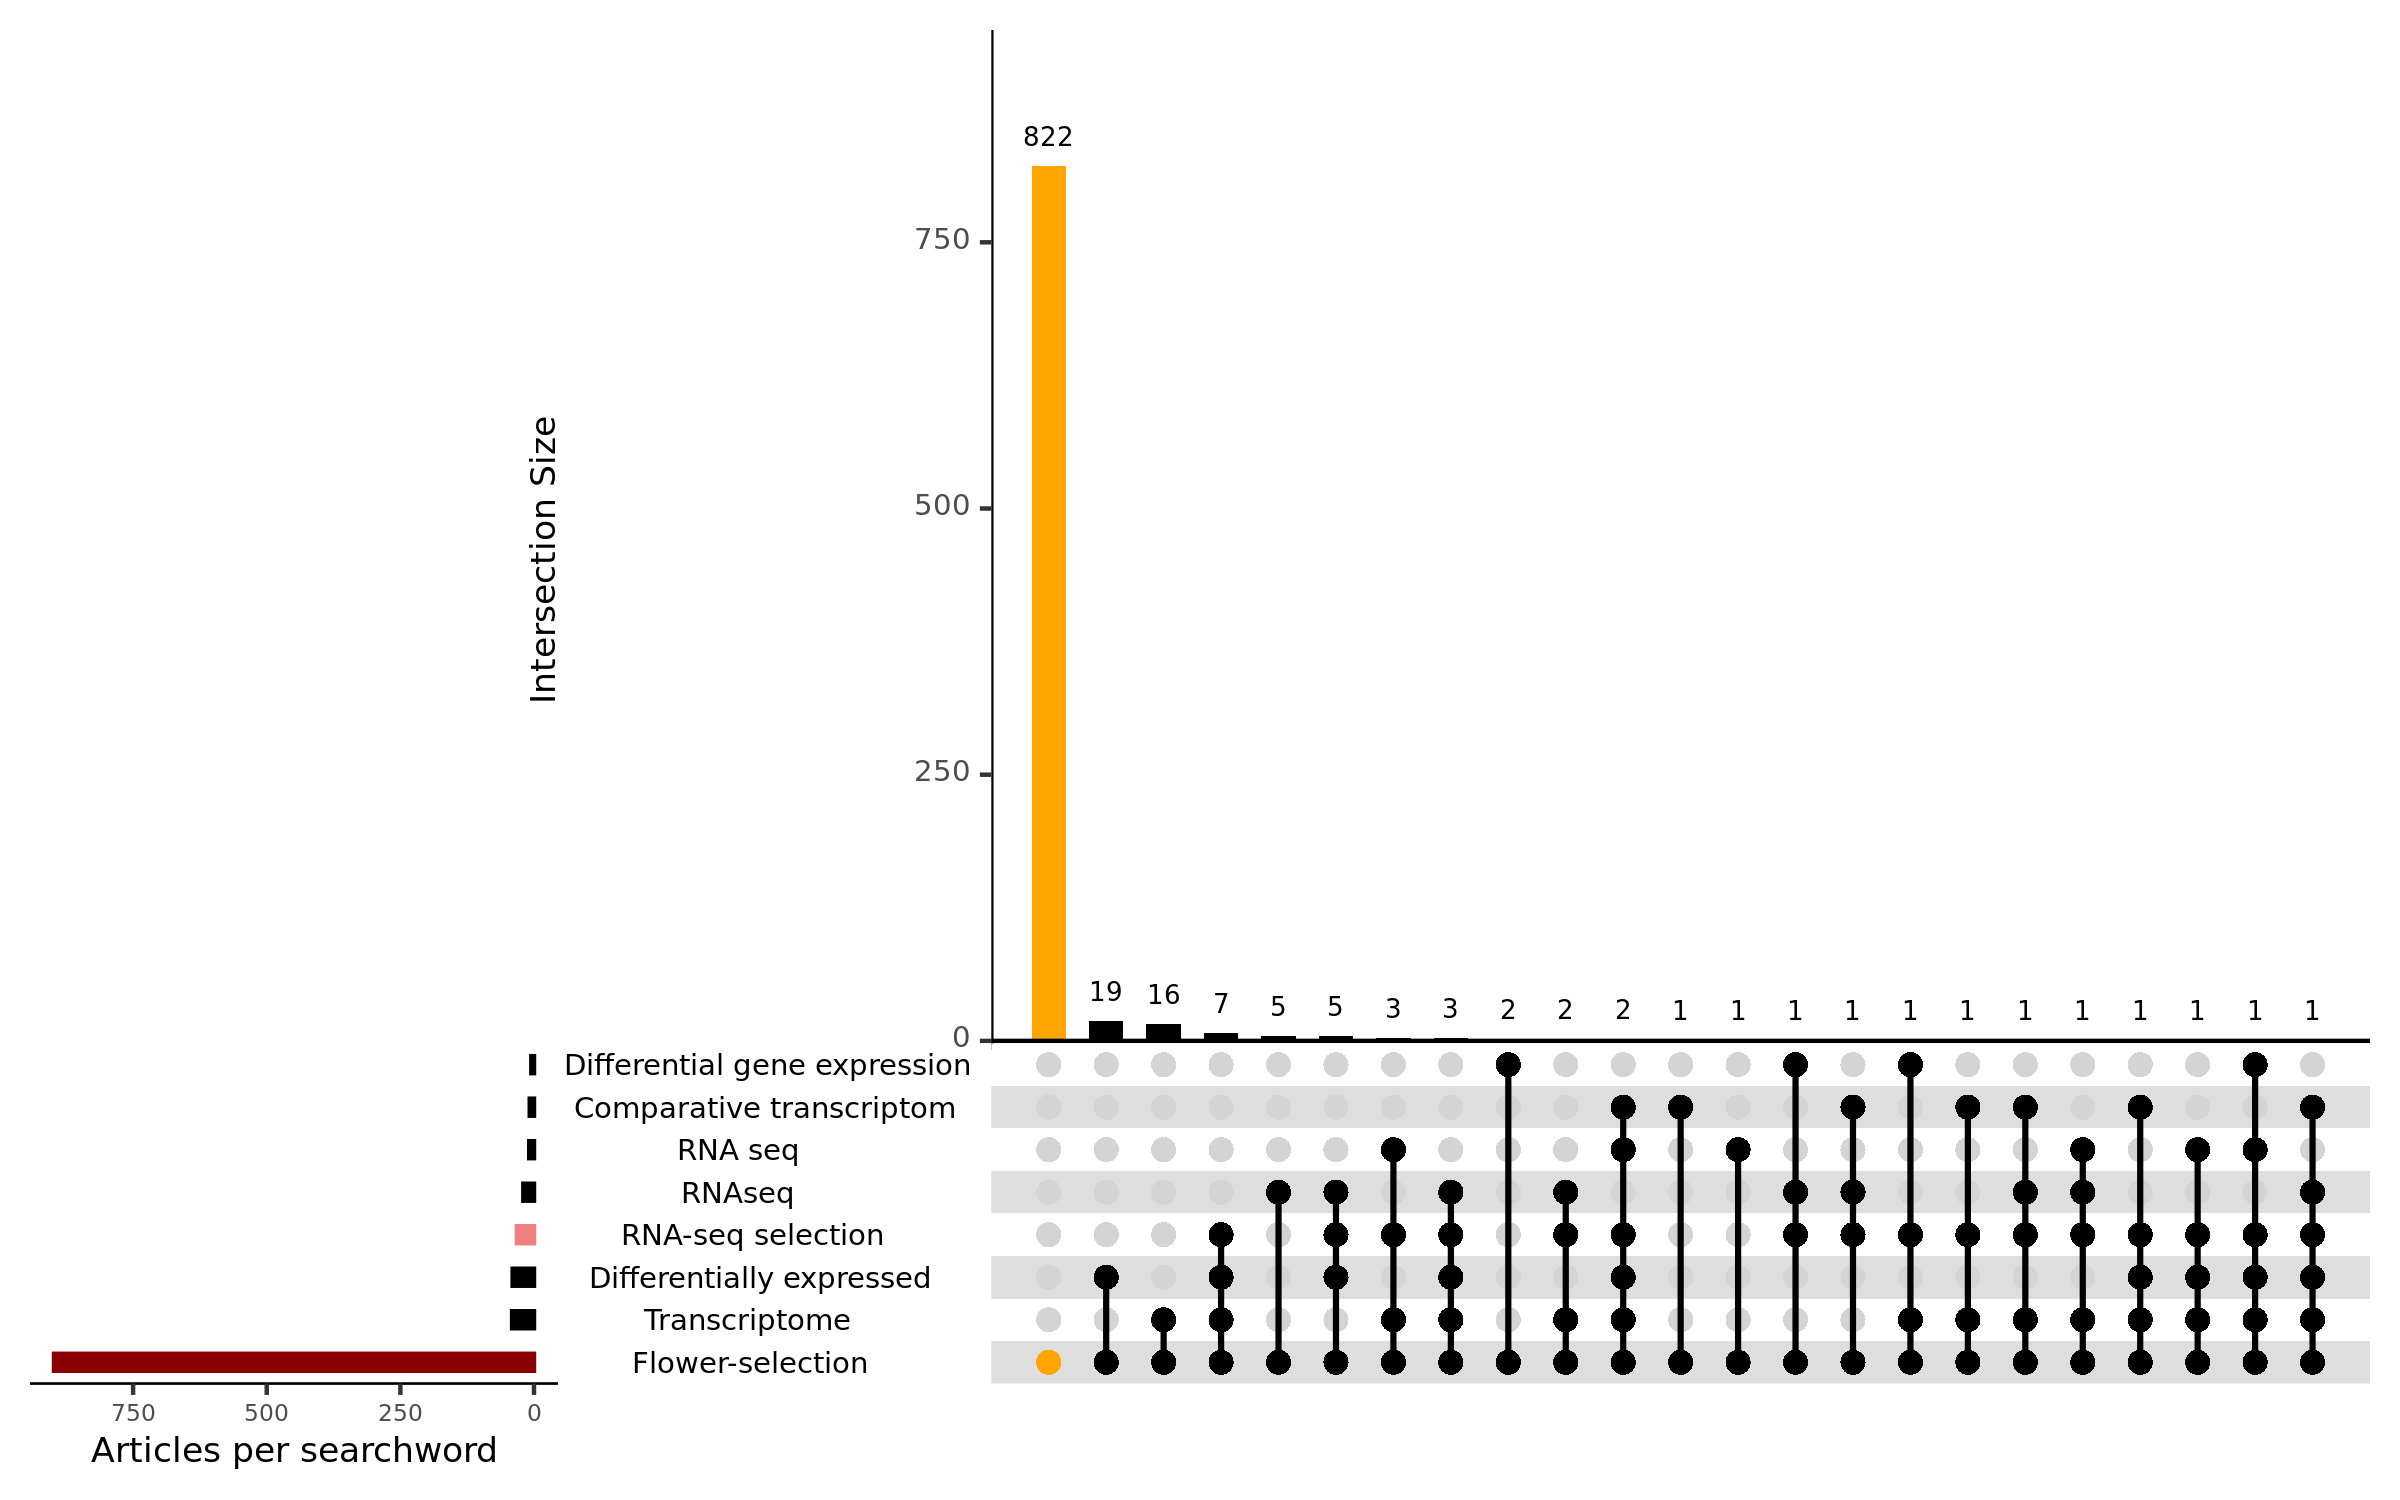

In [80]:
options(repr.plot.width = 8, repr.plot.height = 10, repr.plot.res = 300)


p3 <- upset(all1, sets = c("Flower-selection", "Differentially expressed", "Comparative transcriptom", "RNAseq", "RNA seq", "Differential gene expression", "Transcriptome", "RNA-seq selection"),
      order.by = "freq", main.bar.color = "black", matrix.color = "black", shade.color = "lightgrey", sets.bar.color =c("red4", "black", "black", "lightcoral", "black", "black", "black", "black"), matrix.dot.alpha = 30, shade.alpha = 0.75,
      att.color = "red4", set_size.show = F, text.scale = c(1, 1, 1, 0.8, 1, 1), point.size = 2.5,
      queries = list(list(query = intersects, params = list("Flower-selection"), color = "orange", active = T)),
      mainbar.y.label = "Intersection Size", sets.x.label = "Articles per searchword",
     attribute.plots=list(gridrows=40,plots=list(list(plot=histogram, x = "Year"))))
p3
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
png("upset_transcript.png", units="in", width=8, height=8, res=300)
p3
dev.off()

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)


p3 <- upset(all1, sets = c("Flower-selection", "Differentially expressed", "Comparative transcriptom", "RNAseq", "RNA seq", "Differential gene expression", "Transcriptome", "RNA-seq selection"),
      order.by = "freq", main.bar.color = "black", matrix.color = "black", shade.color = "lightgrey", sets.bar.color =c("red4", "black", "black", "lightcoral", "black", "black", "black", "black"), matrix.dot.alpha = 30, shade.alpha = 0.75,
      att.color = "red4", set_size.show = F, text.scale = c(1, 1, 1, 0.8, 1, 1), point.size = 2.5,
      queries = list(list(query = intersects, params = list("Flower-selection"), color = "orange", active = T)),
      mainbar.y.label = "Intersection Size", sets.x.label = "Articles per searchword")
p3
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
png("upset_transcript_alone.png", units="in", width=8, height=5, res=300)
p3
dev.off()

# Summarizing plots for thesis figures

In [54]:
library(patchwork)


Attaching package: ‘patchwork’

The following object is masked from ‘package:cowplot’:

    align_plots



In [55]:
# supplementary
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
options(repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 200)

patched <- freq|wc
png("freq_wc_sup1.png", units="in", width=12, height=5, res=200)
patched + plot_annotation(tag_levels = 'A') & 
  theme(plot.tag = element_text(size = 16))
dev.off()
#ggsave("freq_wc_sup.png")
patched + plot_annotation(tag_levels = 'A') & 
  theme(plot.tag = element_text(size = 16))

ERROR: Error in eval(expr, envir, enclos): object 'freq' not found


In [ ]:
sessionInfo()